## Walktimes to TTC Stop
# Introduction

In this tutorial we will analyse walk times from address points within the City of Toronto to the Toronto Transit Commission (TTC) Stops. TTC stops can include subway, LRT, street car and bus. The analysis will use Panada to perform the network calculation. The results will be displayed City wide and at the level of an individual City of Toronto Neighbourhood Improvement Area. Neighbourhood Improvement Areas have been chosen as one of the domains used to determine them is the physical surroundings including access to transportation.

The analysis will use data from the City of Toronto's Open Data site including TTC Stop (https://open.toronto.ca/dataset/ttc-routes-and-schedules/), the City of Toronto's pedestrian network (https://open.toronto.ca/dataset/pedestrian-network/), Toronto One Address Repository address point data (https://open.toronto.ca/dataset/address-points-municipal-toronto-one-address-repository/) and Neighbourhood Improvement Areas (https://open.toronto.ca/dataset/neighbourhood-improvement-areas/).

The TTC Routes and Schedules zip file contains route definitions, stop patterns, stop locations, and schedules. For this tutorial we will be using the stops.txt file.

The City of Toronto pedestrian network was a collective effort by the City of Toronto's Information and Technology Division's Data Analytics and Visualization team (DAV) and the City of Toronto's Transportation Services Division. A pedestrian network based on sidewalk centerlines and pedestrian-assets (e.g., sidewalks, crosswalks, pedestrian controlled crossings) was created with the focus being placed on the topological consistency over spatial accuracy. Meaning that the sidewalk centerlines are not necessarily spatially located along with the actual locations of the sidewalk geographically, but the connections between different sidewalk segments were maintained as being a higher priority.

The City of Toronto address point data contains over 500,000 address points within the city. A readme file is also included which explains the each of the attributes.

Neighbourhood Improvement Areas are specially-selected and designated neighbourhoods in the City of Toronto found to have inequities on several indicators of well-being. Currently 31 out of 140 neighbourhoods are designated as NIAs as part of the Toronto Strong Neighbourhoods 2020 (TSNS2020) project. Please see the link for further information (https://www.toronto.ca/city-government/data-research-maps/research-reports/social-reports/toronto-strong-neighbourhoods-strategy-2020/).

In [2]:
!pip install geopandas

  Using cached geopandas-0.12.1-py3-none-any.whl (1.1 MB)
  Using cached pyproj-3.4.0-cp38-cp38-win_amd64.whl (4.8 MB)
  Using cached Fiona-1.8.22-cp38-cp38-win_amd64.whl (21.7 MB)
  Using cached Shapely-1.8.5.post1-cp38-cp38-win_amd64.whl (1.3 MB)
  Using cached cligj-0.7.2-py3-none-any.whl (7.1 kB)
  Using cached click_plugins-1.1.1-py2.py3-none-any.whl (7.5 kB)
  Using cached munch-2.5.0-py2.py3-none-any.whl (10 kB)


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
osmnx 1.2.2 requires numpy>=1.22, but you have numpy 1.21.5 which is incompatible.
osmnx 1.2.2 requires pandas>=1.4, but you have pandas 1.3.3 which is incompatible.
osmnx 1.2.2 requires Rtree>=1.0, but you have rtree 0.9.7 which is incompatible.


In [4]:
!pip install psycopg2

     ---------------------------------------- 1.2/1.2 MB 36.8 MB/s eta 0:00:00


In [6]:
!pip install pandana

     -------------------------------------- 131.1/131.1 kB 7.6 MB/s eta 0:00:00


In [17]:
!pip install basemap --user

  Using cached basemap-1.3.6-cp38-cp38-win_amd64.whl (487 kB)
  Using cached basemap_data-1.3.2-py2.py3-none-any.whl (30.5 MB)
  Using cached contourpy-1.0.6-cp38-cp38-win_amd64.whl (163 kB)


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pandas-profiling 3.4.0 requires matplotlib<3.6,>=3.2, but you have matplotlib 3.6.2 which is incompatible.


In [19]:
!pip install geoalchemy2

     ---------------------------------------- 50.5/50.5 kB ? eta 0:00:00


In [21]:
!pip install mapclassify

In [1]:
import pandas as pd
import geopandas as gpd
import pandas as pd
import os
import shapely
import numpy as np
import psycopg2
import networkx as nx
import multiprocessing as mp
import pandana as pdna
import h5py
import shapefile
import pyproj
import matplotlib.pyplot as plt
from pandana import Network
from mpl_toolkits.basemap import Basemap
from shapely import ops
from shapely import wkt
from shapely.geometry import Polygon, LineString, Point, box
from pandana import Network
from geoalchemy2 import Geometry, WKTElement
from sqlalchemy import *
from shapely.geometry import *
from fiona.crs import from_epsg
from mpl_toolkits.axes_grid1 import make_axes_locatable
import mapclassify


%matplotlib inline

pd.options.display.max_rows = 120

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

## Step 1: Importing and Cleaning Data
# Importing Data
We can read the ttc stop text file and create geometry using the latitude longitude columns supplied in the data. We can use the geopandas.read_file function to read the pednet, address and Neighbourhood Improvement Areas ESRI shape files and reproject them to EPSG 2019. Please see the link for the description of EPSG 2019 (https://epsg.io/2019).

# Read TTC Stop Data
Read the TTC Stop data text file and create the spatial layer using the latitude and longitude provided in the file. The layer will be reprojected to EPSG 2019.

In [2]:
# reading ttc stop csv file
# https://open.toronto.ca/dataset/ttc-routes-and-schedules/
# Go to Download Data
ttc_stop = pd.read_csv('./stops.txt', delimiter= ',')
ttc_stop

stop_id  stop_code                         stop_name  stop_desc   stop_lat   stop_lon  zone_id  stop_url  location_type  parent_station  stop_timezone  wheelchair_boarding
0         262        662         Danforth Rd at Kennedy Rd        NaN  43.714379 -79.260939      NaN       NaN            NaN             NaN            NaN                    1
1         263        929        Davenport Rd at Bedford Rd        NaN  43.674448 -79.399659      NaN       NaN            NaN             NaN            NaN                    1
2         264        940         Davenport Rd at Dupont St        NaN  43.675511 -79.401938      NaN       NaN            NaN             NaN            NaN                    2
3         265       1871    Davisville Ave at Cleveland St        NaN  43.702088 -79.378112      NaN       NaN            NaN             NaN            NaN                    1
4         266      11700            Disco Rd at Attwell Dr        NaN  43.701362 -79.594843      NaN       NaN            NaN             NaN            NaN                    1
...       ...        ...                               ...        ...        ...        ...      ...       ...            ...             ...            ...                  ...
9416    24516      16275       Gerrard St East at Yonge St        NaN  43.659208 -79.382000      NaN       NaN            NaN             NaN            NaN                    1
9417    24517      16276         Gerrard St West at Bay St        NaN  43.658393 -79.385013      NaN       NaN            NaN             NaN            NaN                    1
9418    24518      16277         Gerrard St West at Bay St        NaN  43.658626 -79.384739      NaN       NaN            NaN             NaN            NaN                    1
9419    24519      16278   Gerrard St West at Elizabeth St        NaN  43.658079 -79.386494      NaN       NaN            NaN             NaN            NaN                    1
9420    24520      16281  Castlemore Ave at Hammersly Blvd        NaN  43.903650 -79.270447      NaN       NaN            NaN             NaN            NaN                    1

[9421 rows x 12 columns]

In [3]:
#include columns needed for the project and renaming stop_lat and stop_lon columns
ttc_stop = ttc_stop[['stop_id', 'stop_code','stop_name','stop_lat', 'stop_lon']]
ttc_stop = ttc_stop.rename(columns={'stop_lat': 'latitude','stop_lon':'longitude' })
ttc_stop

stop_id  stop_code                         stop_name   latitude  longitude
0         262        662         Danforth Rd at Kennedy Rd  43.714379 -79.260939
1         263        929        Davenport Rd at Bedford Rd  43.674448 -79.399659
2         264        940         Davenport Rd at Dupont St  43.675511 -79.401938
3         265       1871    Davisville Ave at Cleveland St  43.702088 -79.378112
4         266      11700            Disco Rd at Attwell Dr  43.701362 -79.594843
...       ...        ...                               ...        ...        ...
9416    24516      16275       Gerrard St East at Yonge St  43.659208 -79.382000
9417    24517      16276         Gerrard St West at Bay St  43.658393 -79.385013
9418    24518      16277         Gerrard St West at Bay St  43.658626 -79.384739
9419    24519      16278   Gerrard St West at Elizabeth St  43.658079 -79.386494
9420    24520      16281  Castlemore Ave at Hammersly Blvd  43.903650 -79.270447

[9421 rows x 5 columns]

In [4]:
# create geopanda dataframe add crs lat long
ttc_stop['geometry'] = list(zip(ttc_stop.longitude, ttc_stop.latitude))
ttc_stop['geometry'] = ttc_stop['geometry'].apply(Point)

# reprojecting epsg 4386 (wgs84) to epsg 2019 (mtm nad 27)
crs = {'init': 'epsg:4326'}
ttc_stop = gpd.GeoDataFrame(ttc_stop, crs=crs, geometry='geometry')
ttc_stop = ttc_stop.to_crs({'init': 'epsg:2019'})

# calculating x and y which will be used later to find nearest ttc stop to address 
ttc_stop['x'] = ttc_stop.geometry.x
ttc_stop['y'] = ttc_stop.geometry.y

C:\Users\humbe\anaconda3\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\humbe\anaconda3\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [5]:
ttc_stop.crs

<Derived Projected CRS: EPSG:2019>
Name: NAD27(76) / MTM zone 10
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Canada - Ontario - between 81°W and 78°W: south of 46°N in area to west of 80°15'W, south of 47°N in area between 80°15'W and 79°30'W, entire province between 79°30'W and 78°W.
- bounds: (-81.0, 42.26, -77.99, 47.33)
Coordinate Operation:
- name: MTM zone 10
- method: Transverse Mercator
Datum: North American Datum 1927 (1976)
- Ellipsoid: Clarke 1866
- Prime Meridian: Greenwich

In [6]:
ttc_stop

stop_id  stop_code                         stop_name   latitude  longitude                        geometry              x             y
0         262        662         Danforth Rd at Kennedy Rd  43.714379 -79.260939  POINT (324064.544 4841414.808)  324064.544438  4.841415e+06
1         263        929        Davenport Rd at Bedford Rd  43.674448 -79.399659  POINT (312891.267 4836955.833)  312891.267226  4.836956e+06
2         264        940         Davenport Rd at Dupont St  43.675511 -79.401938  POINT (312707.354 4837073.706)  312707.354330  4.837074e+06
3         265       1871    Davisville Ave at Cleveland St  43.702088 -79.378112  POINT (314624.256 4840028.795)  314624.255719  4.840029e+06
4         266      11700            Disco Rd at Attwell Dr  43.701362 -79.594843  POINT (297155.498 4839945.292)  297155.497545  4.839945e+06
...       ...        ...                               ...        ...        ...                             ...            ...           ...
9416    24516      16275       Gerrard St East at Yonge St  43.659208 -79.382000  POINT (314317.656 4835264.642)  314317.655964  4.835265e+06
9417    24517      16276         Gerrard St West at Bay St  43.658393 -79.385013  POINT (314074.759 4835173.760)  314074.758533  4.835174e+06
9418    24518      16277         Gerrard St West at Bay St  43.658626 -79.384739  POINT (314096.823 4835199.675)  314096.823204  4.835200e+06
9419    24519      16278   Gerrard St West at Elizabeth St  43.658079 -79.386494  POINT (313955.350 4835138.712)  313955.349969  4.835139e+06
9420    24520      16281  Castlemore Ave at Hammersly Blvd  43.903650 -79.270447  POINT (323240.030 4862439.949)  323240.030034  4.862440e+06

[9421 rows x 8 columns]

### Explore TTC Stop

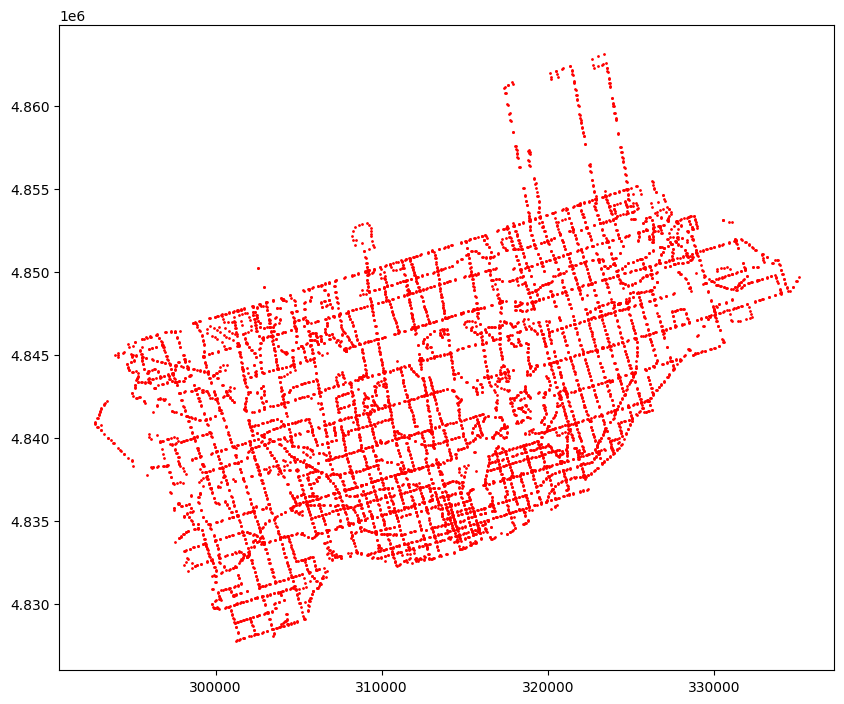

In [7]:
ax = ttc_stop.plot(figsize=(10, 10),color='red', markersize =1)

## Read Pedestrian Network Data
Read the Pedestrian Network line shape file and reproject to EPSG 2019

In [8]:
# reading pednet file
pednet = gpd.read_file("Pedestrian Network Data - 4326.zip")
pednet

FIELD_1  FIELD_2    FIELD_3  FIELD_4                      FIELD_5  FIELD_6 FIELD_7  FIELD_8 FIELD_9    FIELD_10    FIELD_11                                           geometry
0       696841        1      Local        7       Sidewalk on both sides        0    None      NaN    None   93.867680  129.824322  LINESTRING (-79.56396 43.73782, -79.56293 43.7...
1       696842        2  Collector        7       Sidewalk on both sides        0    None      NaN    None   32.546284   44.903807  LINESTRING (-79.56792 43.63618, -79.56752 43.6...
2       696843        3       None        2  Sidewalk on north side only        0    None      NaN    None  117.669206  162.522572  LINESTRING (-79.37791 43.67845, -79.37652 43.6...
3       696844        4       None        7       Sidewalk on both sides        0    None      NaN    None  223.269710  309.035596  LINESTRING (-79.51852 43.70501, -79.51674 43.7...
4       696845        5      Local        7       Sidewalk on both sides        0    None      NaN    None  201.335648  278.478601  LINESTRING (-79.30122 43.77484, -79.29880 43.7...
...        ...      ...        ...      ...                          ...      ...     ...      ...     ...         ...         ...                                                ...
87100   783941    87101    Walkway       11                 City walkway        1      ts   1430.0      ts   32.249129   44.584927  LINESTRING (-79.57840 43.73537, -79.57803 43.7...
87101   783942    87102    Walkway       11                 City walkway        1      ts   1174.0      ts   26.786411   37.023492  LINESTRING (-79.57050 43.71929, -79.57019 43.7...
87102   783943    87103    Walkway       11                 City walkway        1      ts    888.0      ts   32.846849   45.381530  LINESTRING (-79.56002 43.69689, -79.55964 43.6...
87103   783944    87104    Walkway       11                 City walkway        1      ts   2137.0      ts   30.031629   41.511419  LINESTRING (-79.57363 43.72572, -79.57327 43.7...
87104   783945    87105    Walkway       11                 City walkway        1      ts   1867.0      ts   21.617733   29.843369  LINESTRING (-79.53773 43.64694, -79.53748 43.6...

[87105 rows x 12 columns]

In [9]:
pednet.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [10]:
# reprojecting epsg 4386 (wgs84) to epsg 2019 (mtm nad 27)
crs = {'init': 'epsg:4326'}
pednet = gpd.GeoDataFrame(pednet, crs=crs, geometry='geometry')
pednet = pednet.to_crs({'init': 'epsg:2019'})

C:\Users\humbe\anaconda3\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\humbe\anaconda3\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [11]:
# remove length column to avoid confusion
# pednet = pednet[['OBJECTID', 'road_type', 'sdwlk_code', 'sdwlk_desc', 'crosswalk', 'cwalk_type', 'px', 'px_type','geometry']]
pednet = pednet[['FIELD_1', 'FIELD_3', 'FIELD_4', 'FIELD_5', 'FIELD_6', 'FIELD_7', 'FIELD_8', 'FIELD_9','geometry']]
pednet

FIELD_1    FIELD_3  FIELD_4                      FIELD_5  FIELD_6 FIELD_7  FIELD_8 FIELD_9                                           geometry
0       696841      Local        7       Sidewalk on both sides        0    None      NaN    None  LINESTRING (299647.480 4843993.305, 299730.645...
1       696842  Collector        7       Sidewalk on both sides        0    None      NaN    None  LINESTRING (299319.487 4832701.797, 299351.915...
2       696843       None        2  Sidewalk on north side only        0    None      NaN    None  LINESTRING (314644.016 4837403.152, 314756.028...
3       696844       None        7       Sidewalk on both sides        0    None      NaN    None  LINESTRING (303307.301 4840346.899, 303450.851...
4       696845      Local        7       Sidewalk on both sides        0    None      NaN    None  LINESTRING (320802.305 4848122.923, 320996.750...
...        ...        ...      ...                          ...      ...     ...      ...     ...                                                ...
87100   783941    Walkway       11                 City walkway        1      ts   1430.0      ts  LINESTRING (298484.120 4843722.537, 298514.329...
87101   783942    Walkway       11                 City walkway        1      ts   1174.0      ts  LINESTRING (299119.187 4841934.761, 299144.363...
87102   783943    Walkway       11                 City walkway        1      ts    888.0      ts  LINESTRING (299961.620 4839445.526, 299992.729...
87103   783944    Walkway       11                 City walkway        1      ts   2137.0      ts  LINESTRING (298868.080 4842649.076, 298896.374...
87104   783945    Walkway       11                 City walkway        1      ts   1867.0      ts  LINESTRING (301756.197 4833895.912, 301776.423...

[87105 rows x 9 columns]

## Explore the Pedestrian Network Data
Create bar plot and plots of pednet

Create a bar plot showing the distribution of road types

<AxesSubplot: title={'center': 'Pednet Road Type Distribution'}, xlabel='Road Types ', ylabel='Number'>

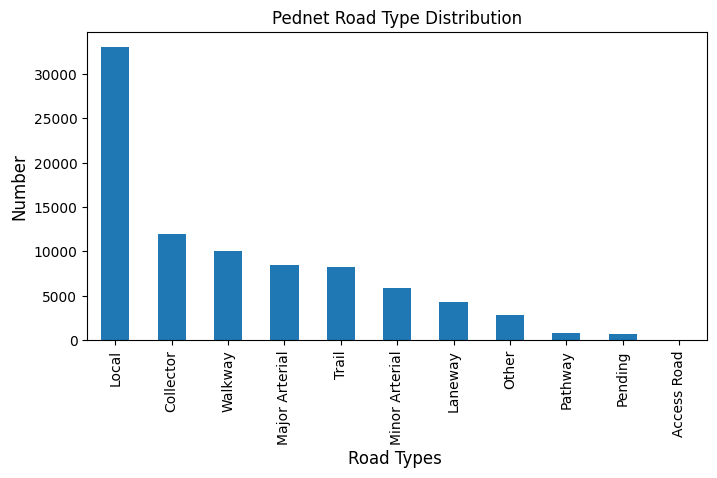

In [12]:
# distribution of road types in pednet

#plot
plt.figure(figsize=(8,4))
#ax= sns.barplot(x.index, x.values, alpha=0.8)
plt.title("Pednet Road Type Distribution")
plt.ylabel('Number', fontsize=12)
plt.xlabel('Road Types ', fontsize=12)

pednet.FIELD_3.value_counts().plot.bar()

### Create a plot of the city wide Pedestrian Network

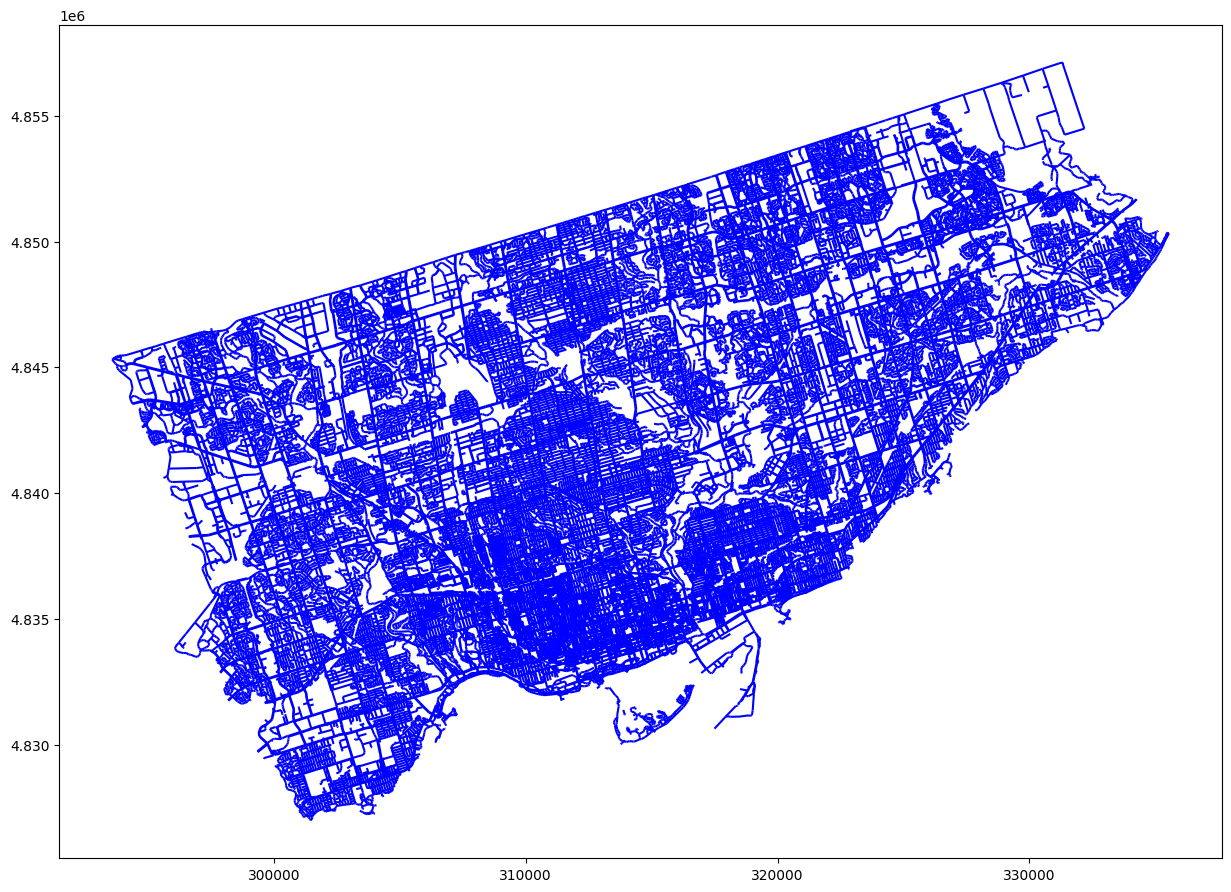

In [13]:
# plotting pednet layer
ax = pednet.plot(figsize=(15, 15),color='blue', markersize =1)

### Create a plot showing the Pedestrian Network at the city block level
In the plot below we see the cases where sidewalks are on both sides of the streets. Single lines represent several different features including local roads, walkways, laneways or private roads.

[(311000.0, 312000.0), (4834000.0, 4835000.0)]

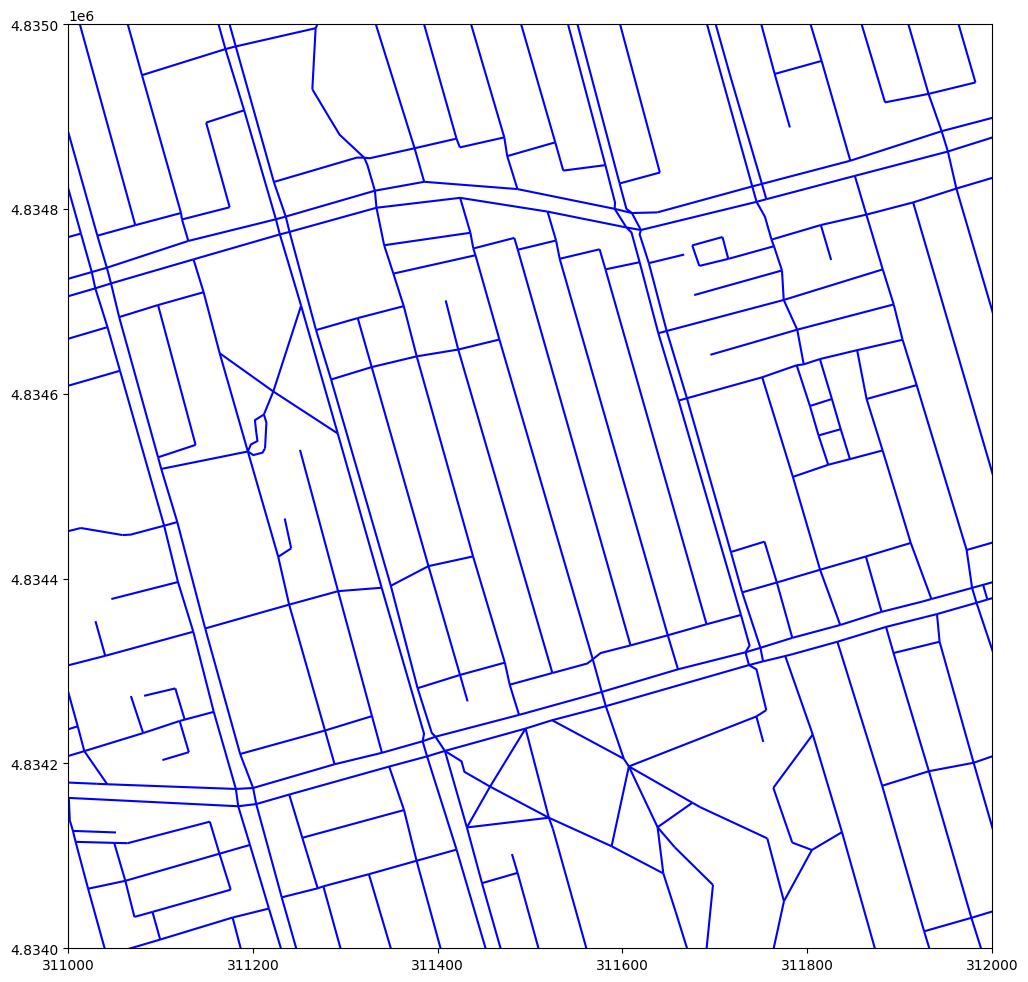

In [14]:
# plotting pednet layer with limits set
ax = pednet.plot(figsize=(12, 12),color='blue', markersize =1)
ax.set(xlim=(311000, 312000), ylim=(4834000, 4835000))

## Load Address Data
Read the Address point shape file and reproject to EPSG 2019

In [15]:
# reading municipal address point shape file
# https://open.toronto.ca/dataset/address-points-municipal-toronto-one-address-repository/
# Go to Download Data
address = gpd.read_file("Municipal address points (wgs84) - geojson.zip")
address

GEO_ID      LINK MAINT_STAG ADDRESS            LFNAME  LO_NUM LONUMSUF  HINUM HINUMSUF ARC_SIDE  DISTANCE   FCODE FCODE_DES      CLASS  NAME           X            Y  LONGITUDE   LATITUDE  OBJECTID     MUN_NAME              WARD_NAME                    geometry
0        5729529   5729516    REGULAR     399    Lake Promenade     399     None    NaN     None        L      4.15  115001   Unknown       Land  None  301607.151  4827443.931 -79.539542  43.586930   1491585    Etobicoke    Etobicoke-Lakeshore  POINT (-79.53954 43.58692)
1        9950585   9950578    REGULAR       7           Hilo Rd       7     None    NaN     None        L     43.77  115001   Unknown       Land  None  301540.011  4827592.989 -79.540374  43.588272   1491586    Etobicoke    Etobicoke-Lakeshore  POINT (-79.54037 43.58826)
2        5729496   5729468    REGULAR     387    Lake Promenade     387     None    NaN     None        L     97.58  115001   Unknown       Land  None  301648.488  4827472.065 -79.539030  43.587184   1491591    Etobicoke    Etobicoke-Lakeshore  POINT (-79.53903 43.58717)
3        5729341   5729332    REGULAR     321    Lake Promenade     321     None    NaN     None        L     63.76  115001   Unknown       Land  None  301926.249  4827620.088 -79.535591  43.588517   1491594    Etobicoke    Etobicoke-Lakeshore  POINT (-79.53559 43.58851)
4        7304577   7304570    REGULAR      22   Thirty Sixth St      22     None    NaN     None        L     62.33  115001   Unknown       Land  None  301937.384  4827737.920 -79.535454  43.589578   1491597    Etobicoke    Etobicoke-Lakeshore  POINT (-79.53545 43.58957)
...          ...       ...        ...     ...               ...     ...      ...    ...      ...      ...       ...     ...       ...        ...   ...         ...          ...        ...        ...       ...          ...                    ...                         ...
525470  30090978  11130066    REGULAR     935    Eglinton Ave W     935     None    NaN     None        L     12.43  115001   Unknown       Land  None  310615.385  4840045.680 -79.427849  43.700339   4611196         York     Toronto-St. Paul's  POINT (-79.42785 43.70034)
525471  30098425    437784    REGULAR     180  Fairview Mall Dr     180     None    NaN     None        L     87.94  115001   Unknown       Land  None  317534.188  4848943.535 -79.341798  43.780343   4613003   North York       Don Valley North  POINT (-79.34180 43.78034)
525472  30098430  30134630    REGULAR      17    Allenbury Gdns      17     None    NaN     None        R    195.20  115001   Unknown  Structure  None  317491.442  4848985.955 -79.342329  43.780726   4613012   North York       Don Valley North  POINT (-79.34233 43.78073)
525473  30112831    437784    REGULAR     188  Fairview Mall Dr     188     None    NaN     None        L    124.13  115001   Unknown       Land  None  317563.408  4848985.222 -79.341434  43.780718   4613018   North York       Don Valley North  POINT (-79.34143 43.78072)
525474  30107192    112267    REGULAR     43B           Park St      43        B    NaN     None        R     56.41  115001   Unknown       Land  None  324486.414  4841160.336 -79.255714  43.710134   4614642  Scarborough  Scarborough Southwest  POINT (-79.25571 43.71013)

[525475 rows x 23 columns]

In [16]:
# change column names from upper to lower case
address.columns = map(str.lower, address.columns)

#include columns needed for the project
address = address[['geo_id', 'maint_stag','address','lfname','x','y','longitude','latitude','objectid','mun_name','ward_name','geometry']]
address

geo_id maint_stag address            lfname           x            y  longitude   latitude  objectid     mun_name              ward_name                    geometry
0        5729529    REGULAR     399    Lake Promenade  301607.151  4827443.931 -79.539542  43.586930   1491585    Etobicoke    Etobicoke-Lakeshore  POINT (-79.53954 43.58692)
1        9950585    REGULAR       7           Hilo Rd  301540.011  4827592.989 -79.540374  43.588272   1491586    Etobicoke    Etobicoke-Lakeshore  POINT (-79.54037 43.58826)
2        5729496    REGULAR     387    Lake Promenade  301648.488  4827472.065 -79.539030  43.587184   1491591    Etobicoke    Etobicoke-Lakeshore  POINT (-79.53903 43.58717)
3        5729341    REGULAR     321    Lake Promenade  301926.249  4827620.088 -79.535591  43.588517   1491594    Etobicoke    Etobicoke-Lakeshore  POINT (-79.53559 43.58851)
4        7304577    REGULAR      22   Thirty Sixth St  301937.384  4827737.920 -79.535454  43.589578   1491597    Etobicoke    Etobicoke-Lakeshore  POINT (-79.53545 43.58957)
...          ...        ...     ...               ...         ...          ...        ...        ...       ...          ...                    ...                         ...
525470  30090978    REGULAR     935    Eglinton Ave W  310615.385  4840045.680 -79.427849  43.700339   4611196         York     Toronto-St. Paul's  POINT (-79.42785 43.70034)
525471  30098425    REGULAR     180  Fairview Mall Dr  317534.188  4848943.535 -79.341798  43.780343   4613003   North York       Don Valley North  POINT (-79.34180 43.78034)
525472  30098430    REGULAR      17    Allenbury Gdns  317491.442  4848985.955 -79.342329  43.780726   4613012   North York       Don Valley North  POINT (-79.34233 43.78073)
525473  30112831    REGULAR     188  Fairview Mall Dr  317563.408  4848985.222 -79.341434  43.780718   4613018   North York       Don Valley North  POINT (-79.34143 43.78072)
525474  30107192    REGULAR     43B           Park St  324486.414  4841160.336 -79.255714  43.710134   4614642  Scarborough  Scarborough Southwest  POINT (-79.25571 43.71013)

[525475 rows x 12 columns]

In [17]:
address.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [18]:
# reprojecting epsg 4386 (wgs84) to epsg 2019 (mtm nad 27)
crs = {'init': 'epsg:4326'}
address = gpd.GeoDataFrame(address, crs=crs, geometry='geometry')
address = address.to_crs({'init': 'epsg:2019'})

C:\Users\humbe\anaconda3\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\humbe\anaconda3\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


### Explore address point data

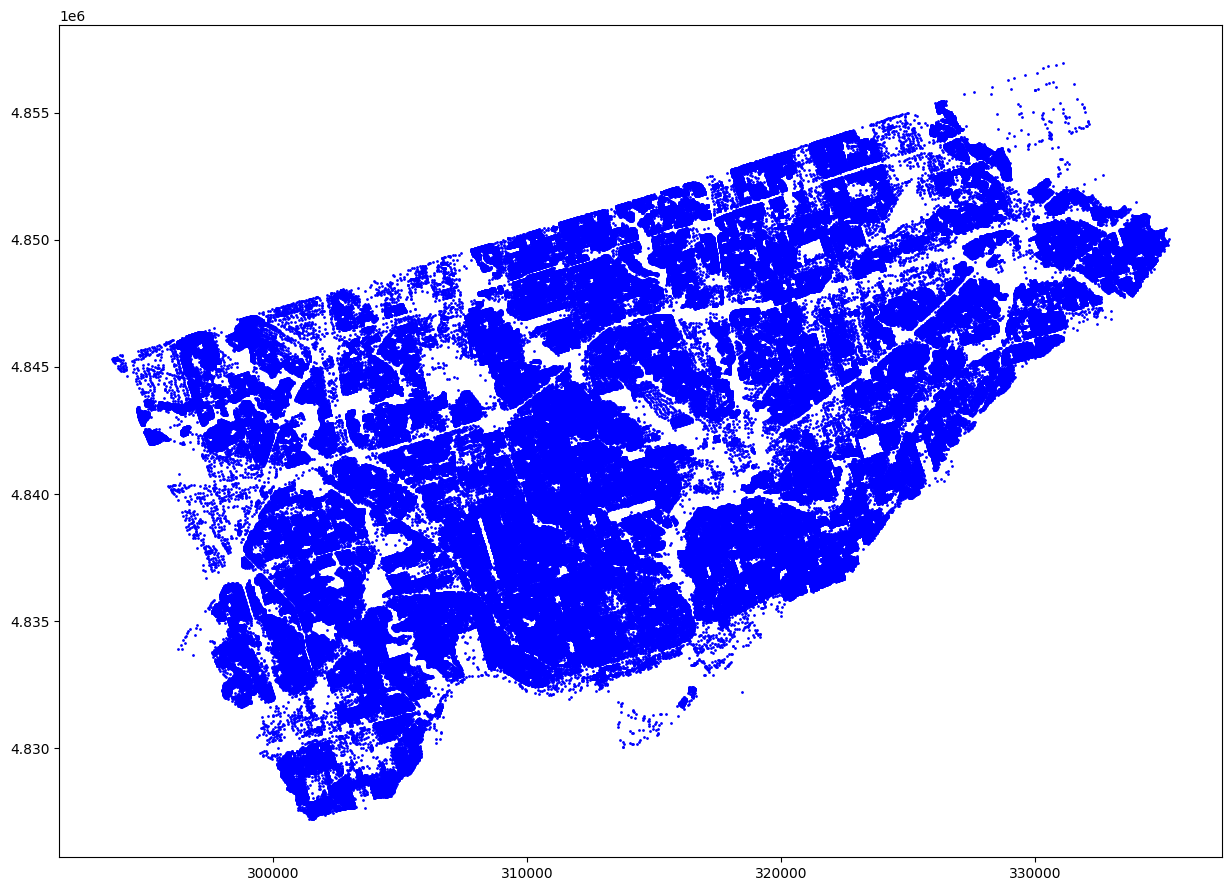

In [19]:
ax = address.plot(figsize=(15, 15),color='blue', markersize =1)

### Create a plot showing the address point data at the city block level


[(311200.0, 311800.0), (4834200.0, 4834800.0)]

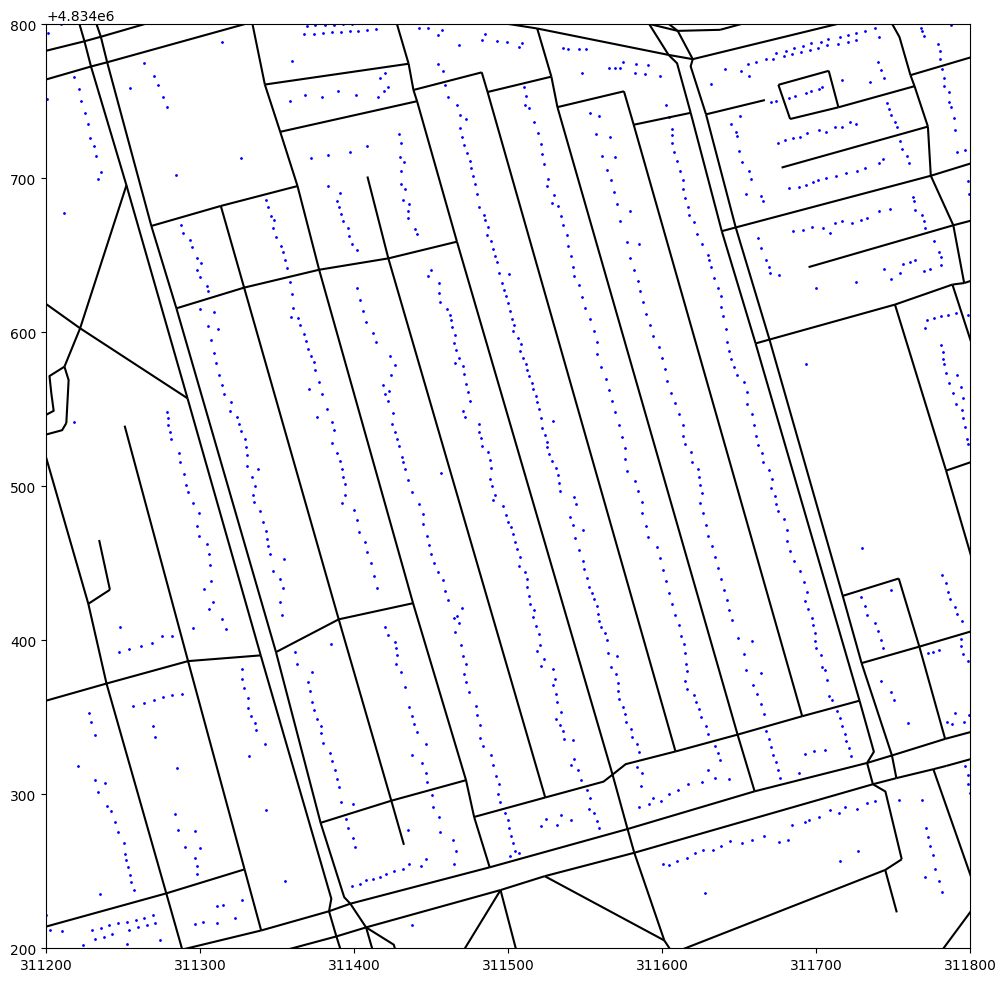

In [20]:
# plotting address layer with limits set
ax = address.plot(figsize=(12, 12),color='blue', markersize =1)
pednet.plot(ax=ax,color='black', markersize =2)
ax.set(xlim=(311200, 311800), ylim=(4834200, 4834800))

## Neighbourhood Improvement Areas
Read the Neighbourhood Improvement Areas polygon shape file and reproject to EPSG 2019

In [21]:
# reading Neighbourhood Improvement Areas polygon shape file
# https://open.toronto.ca/dataset/neighbourhood-improvement-areas/
# Go to Download Data
nia = gpd.read_file("neighbourhood-improvement-areas-wgs84.zip")
nia

AREA_ID    DATE_EFF    DATE_EXP  AREA_AT_ID  AREA_TP_ID  PARNT_AREA AREA_TYPE  AREA_CL_ID AREA_CL AREA_S_CD AREA_L_CD                              AREA_NAME                               AREA_DSC  FEAT_CD FEAT_C_DSC  TR_ID_CRT  TR_ID_EXP           X            Y  LONGITUDE   LATITUDE    OBJECTID                                           geometry
0   25886593  2014-05-12  3000-01-01    25926665         602       49885      CNBH           0    None       027       027           York University Heights (27)           York University Heights (27)        0       None     105211         -1  305679.417  4847086.588 -79.488883  43.765736  16491553.0  POLYGON ((-79.50529 43.75987, -79.50488 43.759...
1   25886723  2014-05-12  3000-01-01    25926718         602       49885      CNBH           0    None       003       003       Thistletown-Beaumond Heights (3)       Thistletown-Beaumond Heights (3)        0       None     105211         -1  299670.030  4844005.846 -79.563491  43.737988  16492401.0  POLYGON ((-79.57751 43.73384, -79.57806 43.734...
2   25886334  2014-05-12  3000-01-01    25926719         602       49885      CNBH           0    None       055       055                  Thorncliffe Park (55)                  Thorncliffe Park (55)        0       None     105211         -1  316874.178  4840655.317 -79.349984  43.707749  16492417.0  POLYGON ((-79.33542 43.70320, -79.33573 43.703...
3   25886704  2014-05-12  3000-01-01    25926708         602       49885      CNBH           0    None       028       028                            Rustic (28)                            Rustic (28)        0       None     105211         -1  304938.033  4841073.295 -79.498091  43.711609  16492241.0  POLYGON ((-79.50384 43.70288, -79.50425 43.704...
4   25886515  2014-05-12  3000-01-01    25926709         602       49885      CNBH           0    None       139       139              Scarborough Village (139)              Scarborough Village (139)        0       None     105211         -1  327594.737  4844116.308 -79.216813  43.738652  16492257.0  POLYGON ((-79.21397 43.72676, -79.21400 43.726...
5   25886994  2014-05-12  3000-01-01    25926710         602       49885      CNBH           0    None       085       085                    South Parkdale (85)                    South Parkdale (85)        0       None     105211         -1  309678.766  4832752.918 -79.439338  43.636700  16492273.0  POLYGON ((-79.42778 43.62979, -79.42948 43.630...
6   25886342  2014-05-12  3000-01-01    25926716         602       49885      CNBH           0    None       061       061                     Taylor-Massey (61)                     Taylor-Massey (61)        0       None     105211         -1  321236.202  4839247.968 -79.295901  43.694998  16492369.0  POLYGON ((-79.28776 43.68978, -79.29269 43.688...
7   25886613  2014-05-12  3000-01-01    25926790         602       49885      CNBH           0    None       021       021                     Humber Summit (21)                     Humber Summit (21)        0       None     105211         -1  300261.014  4846330.825 -79.556175  43.758920  16493553.0  POLYGON ((-79.58064 43.76302, -79.57754 43.763...
8   25886658  2014-05-12  3000-01-01    25926791         602       49885      CNBH           0    None       022       022                        Humbermede (22)                        Humbermede (22)        0       None     105211         -1  301371.929  4844609.257 -79.542367  43.743430  16493569.0  POLYGON ((-79.52628 43.73640, -79.52649 43.736...
9   25886693  2014-05-12  3000-01-01    25926778         602       49885      CNBH           0    None       044       044                   Flemingdon Park (44)                   Flemingdon Park (44)        0       None     105211         -1  318269.615  4841566.821 -79.332646  43.715930  16493361.0  POLYGON ((-79.33791 43.70770, -79.33788 43.707...
10  25886525  2014-05-12  3000-01-01    25926793         602       49885      CNBH           0    None       125       125

In [22]:
# change column names from upper to lower case
nia.columns = map(str.lower, nia.columns)

#include columns needed for the project
nia = nia[['area_id','area_s_cd','area_name','geometry']]
nia

area_id area_s_cd                              area_name                                           geometry
0   25886593       027           York University Heights (27)  POLYGON ((-79.50529 43.75987, -79.50488 43.759...
1   25886723       003       Thistletown-Beaumond Heights (3)  POLYGON ((-79.57751 43.73384, -79.57806 43.734...
2   25886334       055                  Thorncliffe Park (55)  POLYGON ((-79.33542 43.70320, -79.33573 43.703...
3   25886704       028                            Rustic (28)  POLYGON ((-79.50384 43.70288, -79.50425 43.704...
4   25886515       139              Scarborough Village (139)  POLYGON ((-79.21397 43.72676, -79.21400 43.726...
5   25886994       085                    South Parkdale (85)  POLYGON ((-79.42778 43.62979, -79.42948 43.630...
6   25886342       061                     Taylor-Massey (61)  POLYGON ((-79.28776 43.68978, -79.29269 43.688...
7   25886613       021                     Humber Summit (21)  POLYGON ((-79.58064 43.76302, -79.57754 43.763...
8   25886658       022                        Humbermede (22)  POLYGON ((-79.52628 43.73640, -79.52649 43.736...
9   25886693       044                   Flemingdon Park (44)  POLYGON ((-79.33791 43.70770, -79.33788 43.707...
10  25886525       125                          Ionview (125)  POLYGON ((-79.27786 43.72996, -79.27791 43.730...
11  25886640       025            Glenfield-Jane Heights (25)  POLYGON ((-79.52628 43.73640, -79.52721 43.740...
12  25886670       043                  Victoria Village (43)  POLYGON ((-79.30265 43.72472, -79.30210 43.723...
13  25886480       136                        West Hill (136)  POLYGON ((-79.20206 43.76487, -79.20215 43.764...
14  25886531       124                     Kennedy Park (124)  POLYGON ((-79.24549 43.73060, -79.24555 43.730...
15  25886737       006      Kingsview Village-The Westway (6)  POLYGON ((-79.55236 43.70947, -79.55229 43.709...
16  25886386       110         Keelesdale-Eglinton West (110)  POLYGON ((-79.47242 43.67922, -79.47277 43.679...
17  25886380       115                     Mount Dennis (115)  POLYGON ((-79.51329 43.69338, -79.51155 43.693...
18  25886370       112          Beechborough-Greenbrook (112)  POLYGON ((-79.49764 43.69298, -79.49384 43.693...
19  25886548       121                         Oakridge (121)  POLYGON ((-79.26986 43.69584, -79.27009 43.695...
20  25886513       138                    Eglinton East (138)  POLYGON ((-79.24549 43.73060, -79.24602 43.731...
21  25886733       005                   Elms-Old Rexdale (5)  POLYGON ((-79.55512 43.71510, -79.55569 43.716...
22  25886929       072                       Regent Park (72)  POLYGON ((-79.35432 43.65787, -79.35455 43.657...
23  25886870       091                Weston-Pellam Park (91)  POLYGON ((-79.46005 43.66723, -79.46092 43.668...
24  25886652       026              Downsview-Roding-CFB (26)  POLYGON ((-79.50783 43.71776, -79.50854 43.717...
25  25886607       024                       Black Creek (24)  POLYGON ((-79.53488 43.77269, -79.53441 43.772...
26  25886715       002  Mount Olive-Silverstone-Jamestown (2)  POLYGON ((-79.60338 43.75786, -79.60205 43.758...
27  25886473       137                           Woburn (137)  POLYGON ((-79.21128 43.75113, -79.21135 43.751...
28  25886396       111                Rockcliffe-Smythe (111)  POLYGON ((-79.51221 43.66263, -79.51240 43.662...
29  25886362       113                           Weston (113)  POLYGON ((-79.50296 43.69574, -79.50313 43.695...
30  25886466       135                      Morningside (135)  POLYGON ((-79.22552 43.78925, -79.22549 43.789...

In [23]:
nia.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [24]:
# reprojecting epsg 4386 (wgs84) to epsg 2019 (mtm nad 27)
crs = {'init': 'epsg:4326'}
nia = gpd.GeoDataFrame(nia, crs=crs, geometry='geometry')
nia = nia.to_crs({'init': 'epsg:2019'})

C:\Users\humbe\anaconda3\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\humbe\anaconda3\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


### Explore Neighbourhood Improvement Areas

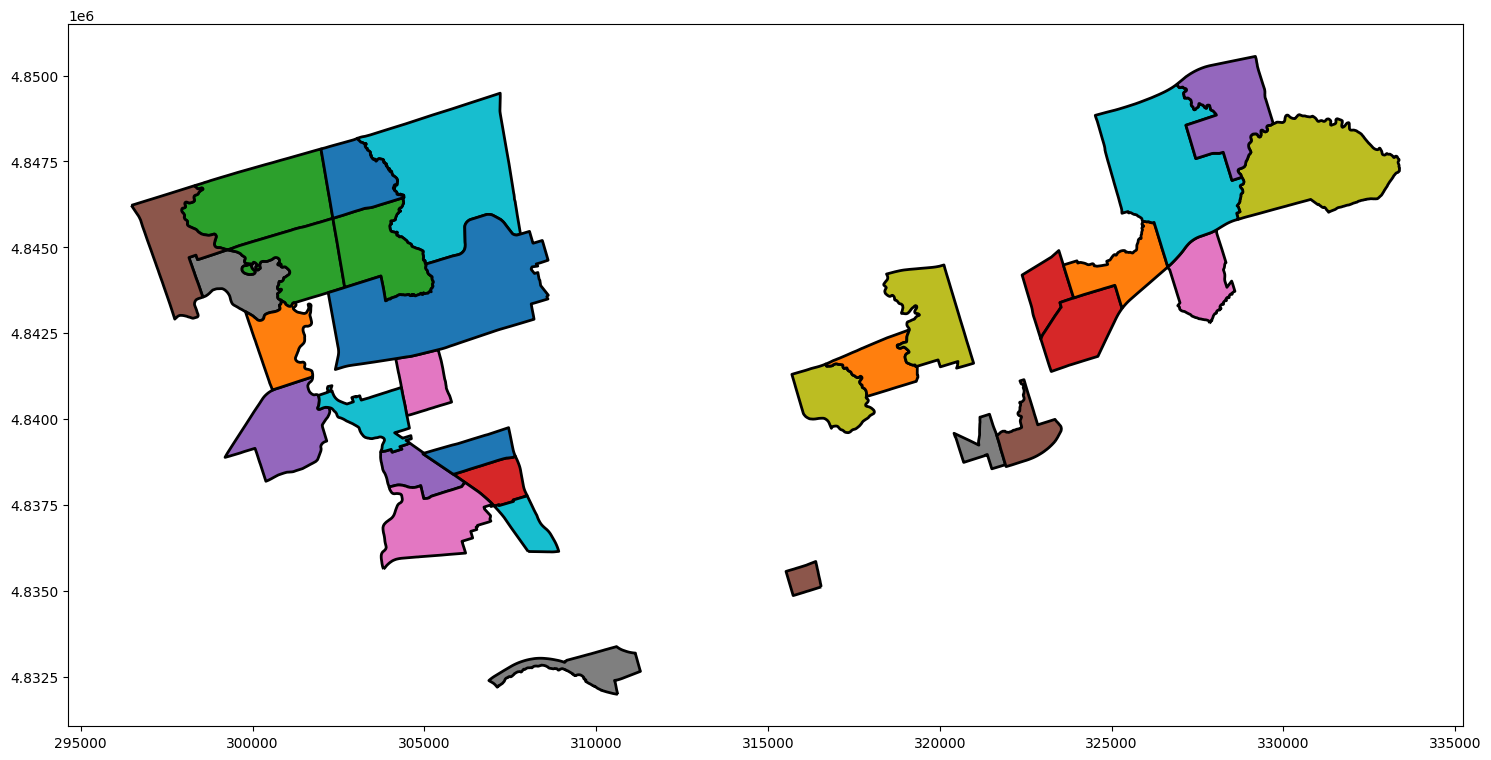

In [25]:
# plot Neighbourhood Improvement Areas
ax = nia.plot(figsize=(18, 13), column='area_name',edgecolor='black', linewidth=2)

# Step 2: Build Pandana Network
Pandana is a Python package that uses contraction hierarchies to perform rapid network calculations including shortest paths and accessibility buffers.

The link provides an introduction to the Pandana Network (https://udst.github.io/pandana/introduction.html).

## Create Network Graph Code Function

In [26]:
# creating network graph code
def create_graph(gdf, precision=3):
    '''Create a networkx given a GeoDataFrame of lines. Every line will
    correspond to two directional graph edges, one forward, one reverse. The
    original line row and direction will be stored in each edge. Every node
    will be where endpoints meet (determined by being very close together) and
    will store a clockwise ordering of incoming edges.
    '''
      
    G = nx.Graph()

    def make_node(coord, precision):
        return tuple(np.round(coord, precision))

    # Edges are stored as (from, to, data), where from and to are nodes.
    def add_edges(row, G):
        geometry = row.geometry
        coords = list(geometry.coords)
        geom_r = LineString(coords[::-1])
        coords_r = geom_r.coords
        start = make_node(coords[0], precision)
        end = make_node(coords[-1], precision)
        # Add forward edge
        fwd_attr ={}
        for k,v in row.items():
            fwd_attr[k]=v
        fwd_attr['forward']= 1
       #fwd_attr['geometry']=  geometry
        fwd_attr['length']=  geometry.length

        fwd_attr['visited']= 0

        G.add_edge(start, end, **fwd_attr)

    gdf.apply(add_edges, axis=1, args=[G])

    return G

### Create a network graph from the function above


In [27]:
# creating network graph
G = create_graph(pednet)
#from G to urbanaccess network model - one node idx,x,y one edge from to weight
#G.edges(data=True)

In [28]:
# get network "from" and "to" from nodes
edges = nx.to_pandas_edgelist(G,'from','to')
to = edges['to'].tolist()
fr = edges['from'].tolist()
fr = list(set(fr))
to = list(set(to))
to.extend(fr)
nodes = list(set(to))
nodes = pd.DataFrame(nodes)
nodes.columns=['x', 'y']
nodes['xy'] = nodes.apply(lambda z: (z.x,z.y),axis=1)

C:\Users\humbe\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


In [29]:
# Assigning node ids to to_node and from_node

nodes['id'] = nodes.index
edges['to_node']=edges['to'].map(nodes.set_index('xy').id)
edges['from_node']=edges['from'].map(nodes.set_index('xy').id)
edges

from                         to  FIELD_1  visited                        FIELD_5     length  FIELD_4 FIELD_7  forward                                           geometry         FIELD_3  FIELD_6 FIELD_9  FIELD_8  to_node  from_node
0       (299647.48, 4843993.305)  (299730.645, 4843949.766)   696841        0         Sidewalk on both sides  93.871829        7    None        1  LINESTRING (299647.4801773648 4843993.30454792...           Local        0    None      NaN    31304      60734
1       (299647.48, 4843993.305)   (299602.64, 4844063.116)   780939        0         Sidewalk on both sides  82.971471        7    None        1  LINESTRING (299602.6398887987 4844063.11581814...           Local        0    None      NaN     5981      60734
2      (299730.645, 4843949.766)   (299811.934, 4843907.77)   722552        0     No sidewalk on either side  91.496355        3    None        1  LINESTRING (299730.64456459746 4843949.7660014...           Local        0    None      NaN    35035      31304
3      (299730.645, 4843949.766)  (299783.527, 4844033.238)   738428        0         Sidewalk on both sides  98.813743        7    None        1  LINESTRING (299730.64456459746 4843949.7660014...           Local        0    None      NaN    43124      31304
4      (299319.487, 4832701.797)  (299351.915, 4832699.012)   696842        0         Sidewalk on both sides  32.547298        7    None        1  LINESTRING (299319.48713045556 4832701.7969447...       Collector        0    None      NaN    37484        452
...                          ...                        ...      ...      ...                            ...        ...      ...     ...      ...                                                ...             ...      ...     ...      ...      ...        ...
87091  (327229.441, 4852966.294)  (327237.367, 4853015.687)   781934        0         Sidewalk on both sides  50.025415        7    None        1  LINESTRING (327229.4406646615 4852966.29367340...  Minor Arterial        0    None      NaN    48702       4127
87092  (307051.475, 4834711.445)  (307056.406, 4834694.336)   781991        0         Sidewalk on both sides  17.805959        7    None        1  LINESTRING (307051.4754708746 4834711.44545915...           Local        0    None      NaN    26016      35695
87093  (309342.013, 4837279.095)   (309284.58, 4837260.629)   783712        0  Laneway without any sidewalks  60.328226       10    None        1  LINESTRING (309284.58048275416 4837260.6294444...         Laneway        0    None      NaN    24345      18090
87094  (321401.322, 4836954.751)  (321449.636, 4836949.596)   783735        0  Laneway without any sidewalks  48.588611       10    None        1  LINESTRING (321401.32159512583 4836954.7514345...         Laneway        0    None      NaN     7214      29622
87095   (321657.857, 4844334.23)  (321674.677, 4844314.245)   783806        0     No sidewalk on either side  26.121263        3    None        1  LINESTRING (321657.8566740737 4844334.22973390...           Local        0    None      NaN      101      48745

[87096 rows x 16 columns]

### Creating and Saving Pandana Network
Create the Pandana Network and save the file in case you lose the network in memory

In [30]:
# creating pandana network

transit_ped_net = pdna.Network(nodes["x"],
                               nodes["y"],
                               edges["from_node"],
                               edges["to_node"],
                               pd.DataFrame([edges['length']]).T,
                               twoway=True)

# saving walkability file is optional. It can be used in the next steps if you don't have transit_ped_net in memory
transit_ped_net.save_hdf5('./walkability.hd5')

### Reading Pandana Network file
This step is only required if you do not already have transit_ped_net in memory

In [31]:
transit_ped_net = pdna.Network.from_hdf5('walkability.hd5')

### Precompute a Horizon Distance
It’s probably a good idea to precompute a given horizon distance so that aggregations don’t perform the network queries unnecessarily. This is done by calling the following code, where 1000 meters is used as the horizon distance:

In [32]:
#precompute a given horizon distance of 1000 meters
transit_ped_net.precompute(1000)
transit_ped_net.edges_df

from     to     length
0      60734  31304  93.871829
1      60734   5981  82.971471
2      31304  35035  91.496355
3      31304  43124  98.813743
4        452  37484  32.547298
...      ...    ...        ...
87091   4127  48702  50.025415
87092  35695  26016  17.805959
87093  18090  24345  60.328226
87094  29622   7214  48.588611
87095  48745    101  26.121263

[87096 rows x 3 columns]

#### Get the nearest pednet intersection node ids for each point from the address and ttc stop layers

In [33]:
#get node_ids for points for each layer
x, y = ttc_stop.x, ttc_stop.y 
ttc_stop["node_ids"] = transit_ped_net.get_node_ids(x, y)
transit_ped_net.set(ttc_stop["node_ids"], name="ttc_stop")

# using x and y coordinates from address that are utm nad27 
x, y = address.x, address.y
address["node_ids"] = transit_ped_net.get_node_ids(x, y)

#### Get 10 nearest ttc stop points
The 10 nearest TTC stops will be determined.

In [34]:
#get nearest points with id
n=10
maxdistance = 5000

transit_ped_net.set_pois("ttc_stop", maxdistance , n, ttc_stop.x, ttc_stop.y)
ttc_stop_walk_distances = transit_ped_net.nearest_pois(maxdistance , "ttc_stop", num_pois=n, include_poi_ids=False)

ttc_stop_walk_distances

1           2           3           4           5            6            7            8            9            10
0      594.369995  701.221985  705.877991  710.801025  767.888977   842.572998   849.742981   907.348022   941.268982  1042.126953
1      160.955002  216.768997  365.160004  396.881012  413.548004   446.268005   447.197998   479.919006   492.638000   502.489990
2      165.317001  394.247986  426.481995  426.882996  456.772003   475.966003   487.903015   515.140015   575.903992   602.668030
3       80.236000   80.236000   80.630997   80.630997  242.779007   254.985001   254.985001   264.424988   295.927002   343.369995
4      175.701004  208.845993  208.845993  212.531006  212.591995   227.794006   379.239014   379.239014   394.144989   448.072998
...           ...         ...         ...         ...         ...          ...          ...          ...          ...          ...
64710  572.877991  597.445984  692.638000  786.043030  786.043030   894.841980   925.143982   925.143982   960.442017   968.817017
64711  765.752014  809.721985  979.935974  983.208008  986.504028  1000.367981  1005.206970  1138.010010  1175.255981  1192.480957
64712  565.002014  593.789978  791.309998  837.007996  973.703003   989.474976  1082.248047  1084.015015  1096.234009  1148.748047
64713  157.220001  192.869003  320.139008  355.500000  362.716003   407.674011   432.082001   459.967010   478.321014   478.321014
64714  490.286011  498.821991  524.018005  533.674011  549.065002   549.193970   651.267029   661.987000   661.987000   672.320007

[64715 rows x 10 columns]

#### Renaming columns

In [35]:
# Rename columns 1 to 10 to d_ttcstop_0 to d_ttcstop_9.

n=10

columns =  ['d_ttcstop_'+str(i) for i in range(0,n,1)]

ttc_stop_walk_distances.columns = columns
ttc_stop_walk_distances

d_ttcstop_0  d_ttcstop_1  d_ttcstop_2  d_ttcstop_3  d_ttcstop_4  d_ttcstop_5  d_ttcstop_6  d_ttcstop_7  d_ttcstop_8  d_ttcstop_9
0       594.369995   701.221985   705.877991   710.801025   767.888977   842.572998   849.742981   907.348022   941.268982  1042.126953
1       160.955002   216.768997   365.160004   396.881012   413.548004   446.268005   447.197998   479.919006   492.638000   502.489990
2       165.317001   394.247986   426.481995   426.882996   456.772003   475.966003   487.903015   515.140015   575.903992   602.668030
3        80.236000    80.236000    80.630997    80.630997   242.779007   254.985001   254.985001   264.424988   295.927002   343.369995
4       175.701004   208.845993   208.845993   212.531006   212.591995   227.794006   379.239014   379.239014   394.144989   448.072998
...            ...          ...          ...          ...          ...          ...          ...          ...          ...          ...
64710   572.877991   597.445984   692.638000   786.043030   786.043030   894.841980   925.143982   925.143982   960.442017   968.817017
64711   765.752014   809.721985   979.935974   983.208008   986.504028  1000.367981  1005.206970  1138.010010  1175.255981  1192.480957
64712   565.002014   593.789978   791.309998   837.007996   973.703003   989.474976  1082.248047  1084.015015  1096.234009  1148.748047
64713   157.220001   192.869003   320.139008   355.500000   362.716003   407.674011   432.082001   459.967010   478.321014   478.321014
64714   490.286011   498.821991   524.018005   533.674011   549.065002   549.193970   651.267029   661.987000   661.987000   672.320007

[64715 rows x 10 columns]

#### Calculating walk distance from address points to ttc_stops and get each point id from ttc stop.


In [36]:
for i in range(10):
    address['d_ttcstop_{}'.format(i)]=address['node_ids'].map(ttc_stop_walk_distances['d_ttcstop_{}'.format(i)])
address

geo_id maint_stag address            lfname           x            y  longitude   latitude  objectid     mun_name              ward_name                        geometry  node_ids  d_ttcstop_0  d_ttcstop_1  d_ttcstop_2  d_ttcstop_3  d_ttcstop_4  d_ttcstop_5  d_ttcstop_6  d_ttcstop_7  d_ttcstop_8  d_ttcstop_9
0        5729529    REGULAR     399    Lake Promenade  301607.151  4827443.931 -79.539542  43.586930   1491585    Etobicoke    Etobicoke-Lakeshore  POINT (301607.060 4827228.149)     59761   465.234009   646.440979   711.565979   732.125000   754.632019   805.987976   868.182983  1116.067017  1118.244995  1252.984985
1        9950585    REGULAR       7           Hilo Rd  301540.011  4827592.989 -79.540374  43.588272   1491586    Etobicoke    Etobicoke-Lakeshore  POINT (301539.918 4827377.205)     61598   274.765991   455.972992   521.098022   541.656982   564.164001   615.520020   677.715027   925.598999   927.776978  1062.516968
2        5729496    REGULAR     387    Lake Promenade  301648.488  4827472.065 -79.539030  43.587184   1491591    Etobicoke    Etobicoke-Lakeshore  POINT (301648.398 4827256.282)     59761   465.234009   646.440979   711.565979   732.125000   754.632019   805.987976   868.182983  1116.067017  1118.244995  1252.984985
3        5729341    REGULAR     321    Lake Promenade  301926.249  4827620.088 -79.535591  43.588517   1491594    Etobicoke    Etobicoke-Lakeshore  POINT (301926.167 4827404.304)     26784   530.028015   555.085999   643.578979   687.627014   823.737976   827.271973   997.377991  1008.479004  1060.868042  1073.604004
4        7304577    REGULAR      22   Thirty Sixth St  301937.384  4827737.920 -79.535454  43.589578   1491597    Etobicoke    Etobicoke-Lakeshore  POINT (301937.302 4827522.134)     57945   347.230011   372.287994   460.781006   504.829010   641.504028   644.473999   820.711975   825.681030   878.070007   890.806030
...          ...        ...     ...               ...         ...          ...        ...        ...       ...          ...                    ...                             ...       ...          ...          ...          ...          ...          ...          ...          ...          ...          ...          ...
525470  30090978    REGULAR     935    Eglinton Ave W  310615.385  4840045.680 -79.427849  43.700339   4611196         York     Toronto-St. Paul's  POINT (310615.552 4839829.763)     35904   185.000000   271.770996   271.770996   306.717010   307.451996   355.407013   374.195007   454.781006   458.019989   479.157013
525471  30098425    REGULAR     180  Fairview Mall Dr  317534.188  4848943.535 -79.341798  43.780343   4613003   North York       Don Valley North  POINT (317534.554 4848727.526)     46340   632.854004   634.572998   670.455994   703.495972   841.856018   883.723999   886.806030   919.067993   950.682007   994.486023
525472  30098430    REGULAR      17    Allenbury Gdns  317491.442  4848985.955 -79.342329  43.780726   4613012   North York       Don Valley North  POINT (317491.806 4848769.945)     43656   576.672974   610.323975   706.882019   739.921997   785.674988   789.713013   830.625000   892.013977   920.150024   953.109009
525473  30112831    REGULAR     188  Fairview Mall Dr  317563.408  4848985.222 -79.341434  43.780718   4613018   North York       Don Valley North  POINT (317563.775 4848769.212)     14237   571.546997   573.265991   731.763000   764.802979   780.549011   825.499023   945.031006   947.982971   974.377014   978.406006
525474  30107192    REGULAR     43B           Park St  324486.414  4841160.336 -79.255714  43.710134   4614642  Scarborough  Scarborough Southwest  POINT (324486.978 4840944.409)     14813   295.657013   298.148987   313.744995   382.744995   397.472992   565.971008   585.206970   587.546997   600.307007   601.940979

[525475 rows x 23 columns]

#### Calculate minutes fields based on distances
We are applying an average pedestrian walking speed of 1.2 m/s which is used by the City of Toronto Transportation Services uses.The link below is to the TRANSPORTATION SERVICES STANDARD OPERATING PRACTICE - TRAFFIC SYSTEMS OPERATIONS document which discusses the standardized walk speed of 1.2 m/s.

https://www.toronto.ca/wp-content/uploads/2019/01/96a8-TS_Traffic-Management_Pedestrian-Timing-Guidelines.pdf

In [37]:
# Calculate minutes fields based on distances. This cell takes 1.5 minutes to run.

address['m_ttcstop_0'] = address.apply(lambda row: row.d_ttcstop_0/(1.2*60), axis=1)
address['m_ttcstop_1'] = address.apply(lambda row: row.d_ttcstop_1/(1.2*60), axis=1)
address['m_ttcstop_2'] = address.apply(lambda row: row.d_ttcstop_2/(1.2*60), axis=1)
address['m_ttcstop_3'] = address.apply(lambda row: row.d_ttcstop_3/(1.2*60), axis=1)
address['m_ttcstop_4'] = address.apply(lambda row: row.d_ttcstop_4/(1.2*60), axis=1)
address['m_ttcstop_5'] = address.apply(lambda row: row.d_ttcstop_5/(1.2*60), axis=1)
address['m_ttcstop_6'] = address.apply(lambda row: row.d_ttcstop_6/(1.2*60), axis=1)
address['m_ttcstop_7'] = address.apply(lambda row: row.d_ttcstop_7/(1.2*60), axis=1)
address['m_ttcstop_8'] = address.apply(lambda row: row.d_ttcstop_8/(1.2*60), axis=1)
address['m_ttcstop_9'] = address.apply(lambda row: row.d_ttcstop_9/(1.2*60), axis=1)
address

geo_id maint_stag address            lfname           x            y  longitude   latitude  objectid     mun_name              ward_name                        geometry  node_ids  d_ttcstop_0  d_ttcstop_1  d_ttcstop_2  d_ttcstop_3  d_ttcstop_4  d_ttcstop_5  d_ttcstop_6  d_ttcstop_7  d_ttcstop_8  d_ttcstop_9  m_ttcstop_0  m_ttcstop_1  m_ttcstop_2  m_ttcstop_3  m_ttcstop_4  m_ttcstop_5  m_ttcstop_6  m_ttcstop_7  m_ttcstop_8  m_ttcstop_9
0        5729529    REGULAR     399    Lake Promenade  301607.151  4827443.931 -79.539542  43.586930   1491585    Etobicoke    Etobicoke-Lakeshore  POINT (301607.060 4827228.149)     59761   465.234009   646.440979   711.565979   732.125000   754.632019   805.987976   868.182983  1116.067017  1118.244995  1252.984985     6.461583     8.978347     9.882861    10.168403    10.481000    11.194277    12.058097    15.500931    15.531180    17.402569
1        9950585    REGULAR       7           Hilo Rd  301540.011  4827592.989 -79.540374  43.588272   1491586    Etobicoke    Etobicoke-Lakeshore  POINT (301539.918 4827377.205)     61598   274.765991   455.972992   521.098022   541.656982   564.164001   615.520020   677.715027   925.598999   927.776978  1062.516968     3.816194     6.332958     7.237473     7.523014     7.835611     8.548889     9.412709    12.855542    12.885791    14.757180
2        5729496    REGULAR     387    Lake Promenade  301648.488  4827472.065 -79.539030  43.587184   1491591    Etobicoke    Etobicoke-Lakeshore  POINT (301648.398 4827256.282)     59761   465.234009   646.440979   711.565979   732.125000   754.632019   805.987976   868.182983  1116.067017  1118.244995  1252.984985     6.461583     8.978347     9.882861    10.168403    10.481000    11.194277    12.058097    15.500931    15.531180    17.402569
3        5729341    REGULAR     321    Lake Promenade  301926.249  4827620.088 -79.535591  43.588517   1491594    Etobicoke    Etobicoke-Lakeshore  POINT (301926.167 4827404.304)     26784   530.028015   555.085999   643.578979   687.627014   823.737976   827.271973   997.377991  1008.479004  1060.868042  1073.604004     7.361500     7.709528     8.938597     9.550375    11.440805    11.489889    13.852472    14.006653    14.734278    14.911167
4        7304577    REGULAR      22   Thirty Sixth St  301937.384  4827737.920 -79.535454  43.589578   1491597    Etobicoke    Etobicoke-Lakeshore  POINT (301937.302 4827522.134)     57945   347.230011   372.287994   460.781006   504.829010   641.504028   644.473999   820.711975   825.681030   878.070007   890.806030     4.822639     5.170667     6.399736     7.011514     8.909778     8.951028    11.398777    11.467792    12.195417    12.372306
...          ...        ...     ...               ...         ...          ...        ...        ...       ...          ...                    ...                             ...       ...          ...          ...          ...          ...          ...          ...          ...          ...          ...          ...          ...          ...          ...          ...          ...          ...          ...          ...          ...          ...
525470  30090978    REGULAR     935    Eglinton Ave W  310615.385  4840045.680 -79.427849  43.700339   4611196         York     Toronto-St. Paul's  POINT (310615.552 4839829.763)     35904   185.000000   271.770996   271.770996   306.717010   307.451996   355.407013   374.195007   454.781006   458.019989   479.157013     2.569444     3.774597     3.774597     4.259958     4.270167     4.936209     5.197153     6.316403     6.361389     6.654959
525471  30098425    REGULAR     180  Fairview Mall Dr  317534.188  4848943.535 -79.341798  43.780343   4613003   North York       Don Valley North  POINT (317534.554 4848727.526)     46340   632.854004   634.572998   670.455994   703.495972   841.856018   883.723999   886.806030   919.067993   950.682007   994.486023     8.789639     8.813514     9.311889     9.770777    11.692445    12.273944    12.316750    12.76

# Step 3: Visualize Walking Times
In this step we will create a series of visulations illustrating the walking times to the nearest TTC stop across the pedestrian network.

## Walking Times To Closest TTC Stop
In this section we will create a chloropleth map showing the walk times to the closest TTC stop across the City of Toronto. As expected the shortest walk times are along majorial aerterials where TTC stops are located as shown in the second map below where the TTC stops are colour coded red.

Text(0.5, 1.0, 'Walking Times To Closest TTC Stop')

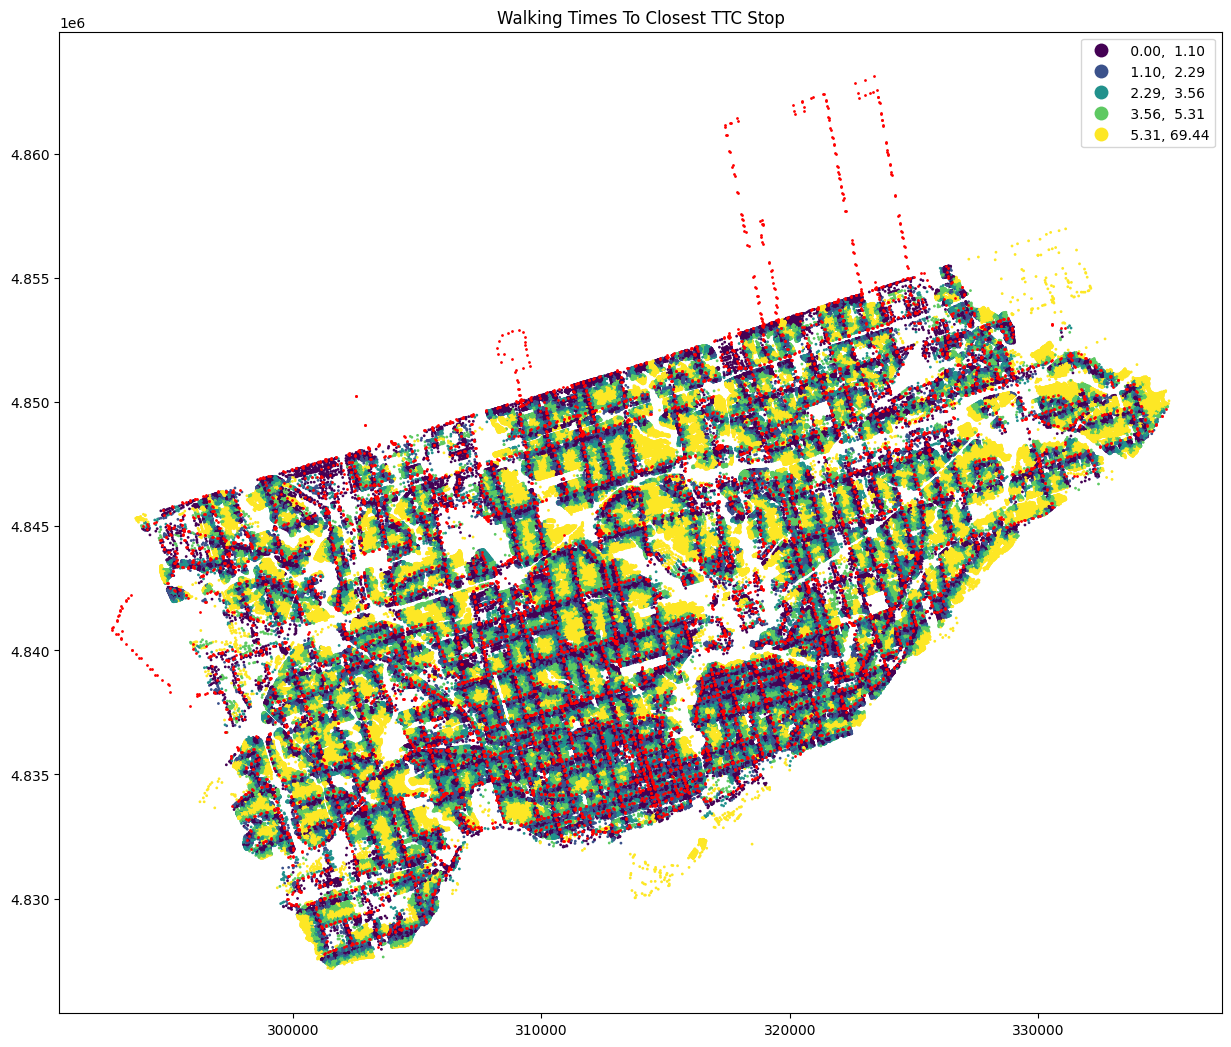

In [38]:
# Walking times To closest TTC Stop with TTC stops added
import mapclassify
ax = address.plot(figsize=(15, 15), column='m_ttcstop_0', scheme='quantiles', legend=True,markersize = 1)
ttc_stop.plot(ax=ax, color='red', markersize =1)
plt.title('Walking Times To Closest TTC Stop')

## Walking Times To Closest TTC Stop with Neighbourhood Improvement Areas

In this step we will invesitgate the walk times in the Neighbourhood Improvement Areas.

## Get the Neighbourhood Improvement Area centre points

To place a label on each Neighbourhood Improvement Areas in the plot we need to find an identifiable point which exists within each polygon so that we can say where we want the text to be placed.

In [39]:
# Here we find the center points, copy our original df to a new df, and then set
# the geometry column to the newly created center points column
# (because a GeoPandas df can only have one geometry column)
nia["center"] = nia["geometry"].centroid
nia_points = nia.copy()
nia_points.set_geometry("center", inplace = True)

Text(0.5, 1.0, 'Walking Times To Closest TTC Stop \n within Neighbourhood Improvement Areas')

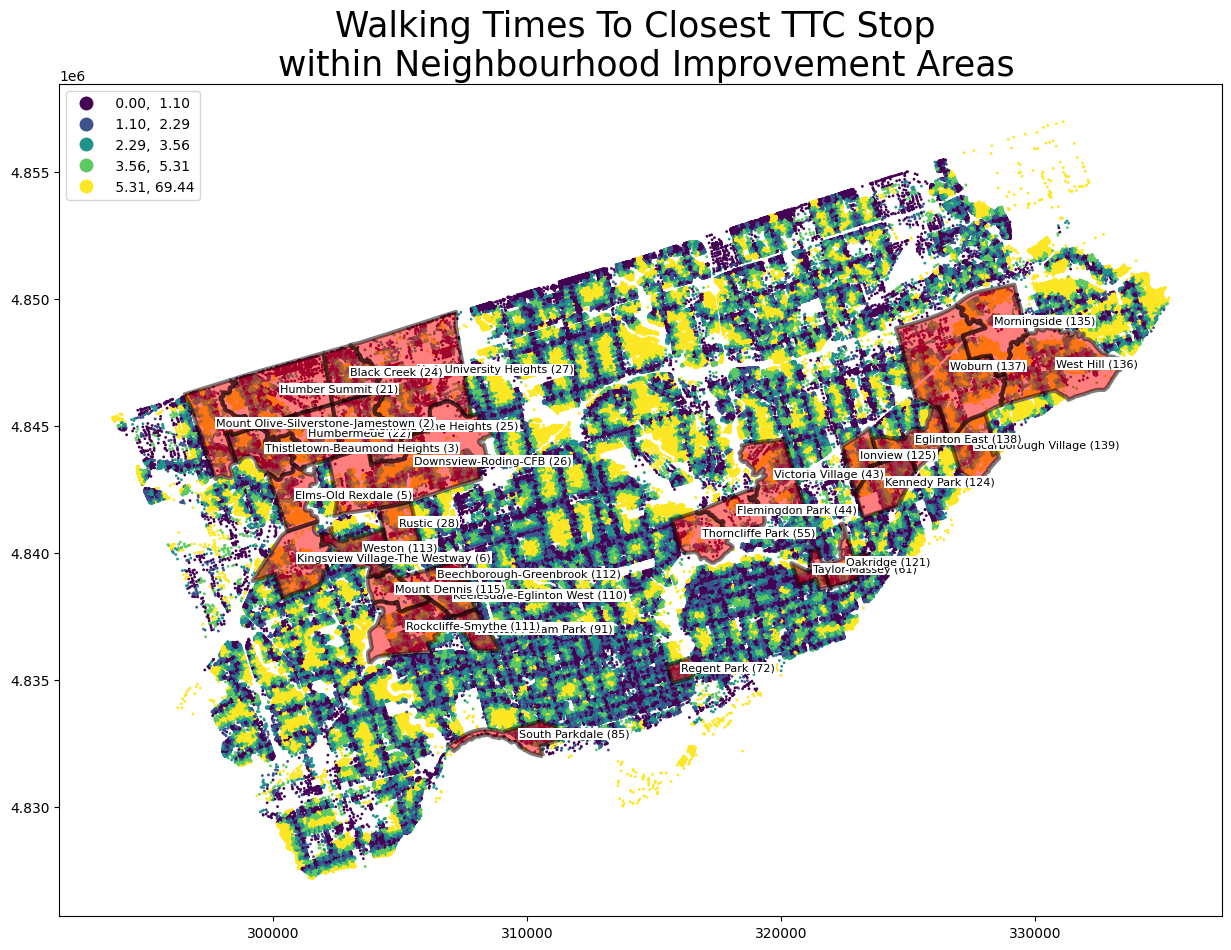

In [40]:
# ploting and adding labels for Neighbourhood Improvement Areas
ax = address.plot(figsize=(15, 15), column='m_ttcstop_0', scheme='quantiles', legend=True,markersize = 1)
nia.plot(ax=ax, edgecolor='black', facecolor='red', linewidth=3, alpha=.5 )
texts = []

# Plot labels and add a white box behind the label using the matplotlib bbox class.
for x, y, label in zip(nia_points.geometry.x, nia_points.geometry.y, nia_points["area_name"]):
    texts.append(plt.text(x, y, label, fontsize = 8, bbox=dict(boxstyle='square,pad=0.1', fc='white', ec='none')))

ax.set_title('Walking Times To Closest TTC Stop \n within Neighbourhood Improvement Areas', fontdict={'fontsize': '25', 'fontweight' : '3'})

#plt.savefig("./walkability_nia.png", dpi=300)

# Addresses within Neighbourhood Improvement Areas

We will now perform a spatial join between Neighbourhood Improvement Area layer and address layer in order to allocate addresses to Neighbourhood Improvement Areas.

In [41]:
# Spatial Join where Neighbourhood Improvement Area polygons are intersected with address points
nia_address = gpd.sjoin(nia, address, op='intersects', how='left')
nia_address

C:\Users\humbe\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3377: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


area_id area_s_cd                     area_name                                           geometry                          center  index_right    geo_id maint_stag  address          lfname           x            y  longitude   latitude  objectid     mun_name              ward_name  node_ids  d_ttcstop_0  d_ttcstop_1  d_ttcstop_2  d_ttcstop_3  d_ttcstop_4  d_ttcstop_5  d_ttcstop_6  d_ttcstop_7  d_ttcstop_8  d_ttcstop_9  m_ttcstop_0  m_ttcstop_1  m_ttcstop_2  m_ttcstop_3  m_ttcstop_4  m_ttcstop_5  m_ttcstop_6  m_ttcstop_7  m_ttcstop_8  m_ttcstop_9
0   25886593       027  York University Heights (27)  POLYGON ((304374.200 4846441.251, 304406.841 4...  POINT (305695.095 4847092.650)       501365   8594884    REGULAR      907       Alness St  306796.237  4848899.935 -79.475200  43.780058   4389010   North York            York Centre     28779   134.416000   173.009995   173.009995   202.054001   500.914001   500.914001   524.044983   524.044983   561.710999   561.710999     1.866889     2.402917     2.402917     2.806306     6.957139     6.957139     7.278403     7.278403     7.801542     7.801542
0   25886593       027  York University Heights (27)  POLYGON ((304374.200 4846441.251, 304406.841 4...  POINT (305695.095 4847092.650)       501372   8594885    REGULAR  909-911       Alness St  306792.657  4848907.661 -79.475245  43.780127   4389031   North York            York Centre     28779   134.416000   173.009995   173.009995   202.054001   500.914001   500.914001   524.044983   524.044983   561.710999   561.710999     1.866889     2.402917     2.402917     2.806306     6.957139     6.957139     7.278403     7.278403     7.801542     7.801542
0   25886593       027  York University Heights (27)  POLYGON ((304374.200 4846441.251, 304406.841 4...  POINT (305695.095 4847092.650)       501369   8594886    REGULAR      913       Alness St  306790.018  4848914.821 -79.475277  43.780192   4389022   North York            York Centre     28779   134.416000   173.009995   173.009995   202.054001   500.914001   500.914001   524.044983   524.044983   561.710999   561.710999     1.866889     2.402917     2.402917     2.806306     6.957139     6.957139     7.278403     7.278403     7.801542     7.801542
0   25886593       027  York University Heights (27)  POLYGON ((304374.200 4846441.251, 304406.841 4...  POINT (305695.095 4847092.650)       501370   8594887    REGULAR  915-917       Alness St  306787.380  4848922.359 -79.475310  43.780260   4389025   North York            York Centre     28779   134.416000   173.009995   173.009995   202.054001   500.914001   500.914001   524.044983   524.044983   561.710999   561.710999     1.866889     2.402917     2.402917     2.806306     6.957139     6.957139     7.278403     7.278403     7.801542     7.801542
0   25886593       027  York University Heights (27)  POLYGON ((304374.200 4846441.251, 304406.841 4...  POINT (305695.095 4847092.650)       501364   8594888    REGULAR      919       Alness St  306785.496  4848928.766 -79.475333  43.780317   4389007   North York            York Centre     28779   134.416000   173.009995   173.009995   202.054001   500.914001   500.914001   524.044983   524.044983   561.710999   561.710999     1.866889     2.402917     2.402917     2.806306     6.957139     6.957139     7.278403     7.278403     7.801542     7.801542
..       ...       ...                           ...                                                ...                             ...          ...       ...        ...      ...             ...         ...          ...        ...        ...       ...          ...                    ...       ...          ...          ...          ...          ...          ...          ...          ...          ...          ...          ...          ...          ...          ...          ...          ...          ...          ...          ...          ...          ...
30  25886466       135             Morningside (135)  POLYGON ((326891.120 4849741.351, 326893.887 

# Count of addresses in Neighbourhood Improvement Areas

We will now do a count of addresses within each Neighbourhood Improvement Areas and visualize the results in a bar plot.

In [42]:
# count of addresses assigned to each Neighbourhood Improvement Area
value_counts = nia_address.area_name.value_counts()
value_counts

Woburn (137)                             8469
Downsview-Roding-CFB (26)                7789
West Hill (136)                          5346
Rockcliffe-Smythe (111)                  5133
Glenfield-Jane Heights (25)              4818
York University Heights (27)             4439
Humber Summit (21)                       3791
Weston-Pellam Park (91)                  3420
Keelesdale-Eglinton West (110)           3123
Kennedy Park (124)                       3037
Weston (113)                             3034
Morningside (135)                        2946
Kingsview Village-The Westway (6)        2797
Mount Olive-Silverstone-Jamestown (2)    2772
Humbermede (22)                          2623
Thistletown-Beaumond Heights (3)         2483
Eglinton East (138)                      2423
Victoria Village (43)                    2337
Oakridge (121)                           2153
Mount Dennis (115)                       1971
Black Creek (24)                         1954
Ionview (125)                     

In [44]:
# count of addresses assigned to each Neighbourhood Improvement Area
value_counts = nia_address.area_name.value_counts()
value_counts

# renaming axixs to area_name and resetting index to nia_address_count
nia_address_counts = value_counts.rename_axis('area_name').reset_index(name='nia_address_count')
nia_address_counts

# merge nia_address_counts with nia_address using the area_name which is shared by both dataframes
nia_address = pd.merge(nia_address, nia_address_counts)

nia_address

area_id area_s_cd                     area_name                                           geometry                          center  index_right    geo_id maint_stag  address          lfname           x            y  longitude   latitude  objectid     mun_name              ward_name  node_ids  d_ttcstop_0  d_ttcstop_1  d_ttcstop_2  d_ttcstop_3  d_ttcstop_4  d_ttcstop_5  d_ttcstop_6  d_ttcstop_7  d_ttcstop_8  d_ttcstop_9  m_ttcstop_0  m_ttcstop_1  m_ttcstop_2  m_ttcstop_3  m_ttcstop_4  m_ttcstop_5  m_ttcstop_6  m_ttcstop_7  m_ttcstop_8  m_ttcstop_9  nia_address_count
0      25886593       027  York University Heights (27)  POLYGON ((304374.200 4846441.251, 304406.841 4...  POINT (305695.095 4847092.650)       501365   8594884    REGULAR      907       Alness St  306796.237  4848899.935 -79.475200  43.780058   4389010   North York            York Centre     28779   134.416000   173.009995   173.009995   202.054001   500.914001   500.914001   524.044983   524.044983   561.710999   561.710999     1.866889     2.402917     2.402917     2.806306     6.957139     6.957139     7.278403     7.278403     7.801542     7.801542               4439
1      25886593       027  York University Heights (27)  POLYGON ((304374.200 4846441.251, 304406.841 4...  POINT (305695.095 4847092.650)       501372   8594885    REGULAR  909-911       Alness St  306792.657  4848907.661 -79.475245  43.780127   4389031   North York            York Centre     28779   134.416000   173.009995   173.009995   202.054001   500.914001   500.914001   524.044983   524.044983   561.710999   561.710999     1.866889     2.402917     2.402917     2.806306     6.957139     6.957139     7.278403     7.278403     7.801542     7.801542               4439
2      25886593       027  York University Heights (27)  POLYGON ((304374.200 4846441.251, 304406.841 4...  POINT (305695.095 4847092.650)       501369   8594886    REGULAR      913       Alness St  306790.018  4848914.821 -79.475277  43.780192   4389022   North York            York Centre     28779   134.416000   173.009995   173.009995   202.054001   500.914001   500.914001   524.044983   524.044983   561.710999   561.710999     1.866889     2.402917     2.402917     2.806306     6.957139     6.957139     7.278403     7.278403     7.801542     7.801542               4439
3      25886593       027  York University Heights (27)  POLYGON ((304374.200 4846441.251, 304406.841 4...  POINT (305695.095 4847092.650)       501370   8594887    REGULAR  915-917       Alness St  306787.380  4848922.359 -79.475310  43.780260   4389025   North York            York Centre     28779   134.416000   173.009995   173.009995   202.054001   500.914001   500.914001   524.044983   524.044983   561.710999   561.710999     1.866889     2.402917     2.402917     2.806306     6.957139     6.957139     7.278403     7.278403     7.801542     7.801542               4439
4      25886593       027  York University Heights (27)  POLYGON ((304374.200 4846441.251, 304406.841 4...  POINT (305695.095 4847092.650)       501364   8594888    REGULAR      919       Alness St  306785.496  4848928.766 -79.475333  43.780317   4389007   North York            York Centre     28779   134.416000   173.009995   173.009995   202.054001   500.914001   500.914001   524.044983   524.044983   561.710999   561.710999     1.866889     2.402917     2.402917     2.806306     6.957139     6.957139     7.278403     7.278403     7.801542     7.801542               4439
...         ...       ...                           ...                                                ...                             ...          ...       ...        ...      ...             ...         ...          ...        ...        ...       ...          ...                    ...       ...          ...          ...          ...          ...          ...          ...          ...          ...          ...          ...          ...          ...          ...          ...          ...          ...          ...       

<AxesSubplot: title={'center': 'Address Count in Neighbourhood Improvement Areas'}, xlabel='Neighbourhood Improvement Areas', ylabel='Number'>

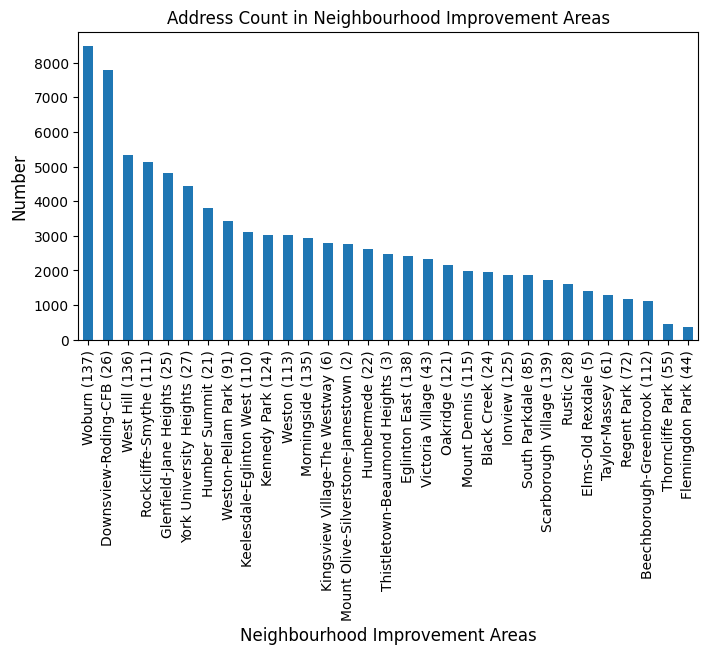

In [45]:
# distribution of addresses in nia_address

#plot
plt.figure(figsize=(8,4))

plt.title("Address Count in Neighbourhood Improvement Areas")
plt.ylabel('Number', fontsize=12)
plt.xlabel('Neighbourhood Improvement Areas', fontsize=12)

nia_address.area_name.value_counts().plot.bar()

Text(0.5, 1.0, 'Walking Times To Closest TTC Stop')

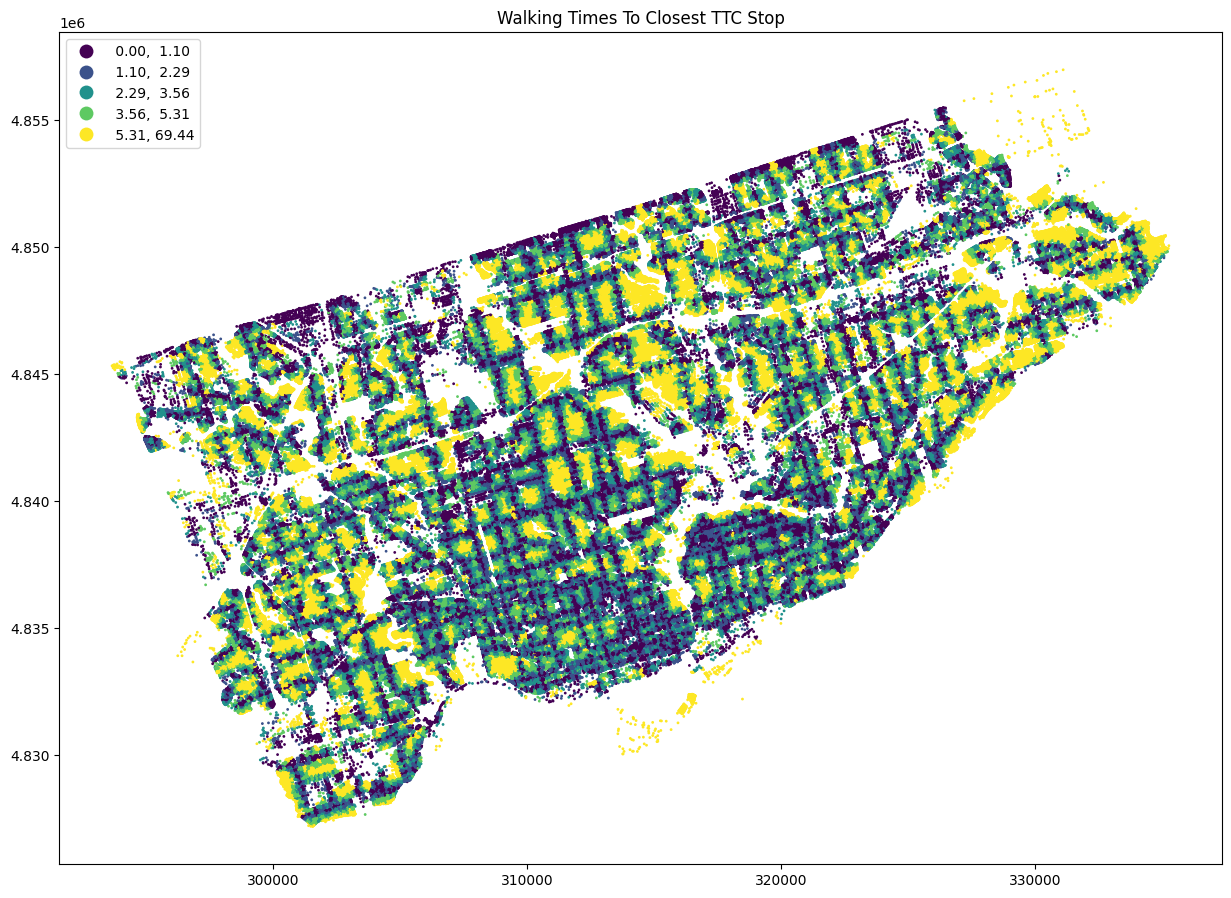

In [46]:
# Walking Times To Closest TTC Stop
ax = address.plot(figsize=(15, 15), column='m_ttcstop_0', scheme='quantiles', legend=True,markersize = 1)
plt.title('Walking Times To Closest TTC Stop')

# Average Walking Times To Closest TTC Stop in Neighbourhood Improvement Areas

We will now use the mean function to calculate the mean walking time to the closest TTC stop for each of the Neighbourhood Improvement Areas.

In [47]:
mins_avgs = nia_address.groupby('area_name')['m_ttcstop_0'].mean()
mins_avgs

area_name
Beechborough-Greenbrook (112)            3.314691
Black Creek (24)                         2.187993
Downsview-Roding-CFB (26)                3.866581
Eglinton East (138)                      3.933311
Elms-Old Rexdale (5)                     5.758494
Flemingdon Park (44)                     3.497886
Glenfield-Jane Heights (25)              4.014364
Humber Summit (21)                       3.062781
Humbermede (22)                          3.570534
Ionview (125)                            3.254044
Keelesdale-Eglinton West (110)           3.289362
Kennedy Park (124)                       2.898198
Kingsview Village-The Westway (6)        4.110792
Morningside (135)                        6.211307
Mount Dennis (115)                       2.856341
Mount Olive-Silverstone-Jamestown (2)    4.058388
Oakridge (121)                           2.556688
Regent Park (72)                         2.169763
Rockcliffe-Smythe (111)                  3.234296
Rustic (28)                             

In [48]:
# renaming axixs to area_name and resetting index to nia_addr_avg_min
nia_addr_avg_min = mins_avgs.rename_axis('area_name').reset_index(name='nia_addr_avg_min')
nia_addr_avg_min

# merge nia_address with nia_addr_avg_min using area_name
nia_address = pd.merge(nia_address, nia_addr_avg_min)

nia_address

area_id area_s_cd                     area_name                                           geometry                          center  index_right    geo_id maint_stag  address          lfname           x            y  longitude   latitude  objectid     mun_name              ward_name  node_ids  d_ttcstop_0  d_ttcstop_1  d_ttcstop_2  d_ttcstop_3  d_ttcstop_4  d_ttcstop_5  d_ttcstop_6  d_ttcstop_7  d_ttcstop_8  d_ttcstop_9  m_ttcstop_0  m_ttcstop_1  m_ttcstop_2  m_ttcstop_3  m_ttcstop_4  m_ttcstop_5  m_ttcstop_6  m_ttcstop_7  m_ttcstop_8  m_ttcstop_9  nia_address_count  nia_addr_avg_min
0      25886593       027  York University Heights (27)  POLYGON ((304374.200 4846441.251, 304406.841 4...  POINT (305695.095 4847092.650)       501365   8594884    REGULAR      907       Alness St  306796.237  4848899.935 -79.475200  43.780058   4389010   North York            York Centre     28779   134.416000   173.009995   173.009995   202.054001   500.914001   500.914001   524.044983   524.044983   561.710999   561.710999     1.866889     2.402917     2.402917     2.806306     6.957139     6.957139     7.278403     7.278403     7.801542     7.801542               4439          3.005300
1      25886593       027  York University Heights (27)  POLYGON ((304374.200 4846441.251, 304406.841 4...  POINT (305695.095 4847092.650)       501372   8594885    REGULAR  909-911       Alness St  306792.657  4848907.661 -79.475245  43.780127   4389031   North York            York Centre     28779   134.416000   173.009995   173.009995   202.054001   500.914001   500.914001   524.044983   524.044983   561.710999   561.710999     1.866889     2.402917     2.402917     2.806306     6.957139     6.957139     7.278403     7.278403     7.801542     7.801542               4439          3.005300
2      25886593       027  York University Heights (27)  POLYGON ((304374.200 4846441.251, 304406.841 4...  POINT (305695.095 4847092.650)       501369   8594886    REGULAR      913       Alness St  306790.018  4848914.821 -79.475277  43.780192   4389022   North York            York Centre     28779   134.416000   173.009995   173.009995   202.054001   500.914001   500.914001   524.044983   524.044983   561.710999   561.710999     1.866889     2.402917     2.402917     2.806306     6.957139     6.957139     7.278403     7.278403     7.801542     7.801542               4439          3.005300
3      25886593       027  York University Heights (27)  POLYGON ((304374.200 4846441.251, 304406.841 4...  POINT (305695.095 4847092.650)       501370   8594887    REGULAR  915-917       Alness St  306787.380  4848922.359 -79.475310  43.780260   4389025   North York            York Centre     28779   134.416000   173.009995   173.009995   202.054001   500.914001   500.914001   524.044983   524.044983   561.710999   561.710999     1.866889     2.402917     2.402917     2.806306     6.957139     6.957139     7.278403     7.278403     7.801542     7.801542               4439          3.005300
4      25886593       027  York University Heights (27)  POLYGON ((304374.200 4846441.251, 304406.841 4...  POINT (305695.095 4847092.650)       501364   8594888    REGULAR      919       Alness St  306785.496  4848928.766 -79.475333  43.780317   4389007   North York            York Centre     28779   134.416000   173.009995   173.009995   202.054001   500.914001   500.914001   524.044983   524.044983   561.710999   561.710999     1.866889     2.402917     2.402917     2.806306     6.957139     6.957139     7.278403     7.278403     7.801542     7.801542               4439          3.005300
...         ...       ...                           ...                                                ...                             ...          ...       ...        ...      ...             ...         ...          ...        ...        ...       ...          ...                    ...       ...          ...          ...          ...          ...          ...          ...          ...          ...          ...   

<AxesSubplot: xlabel='area_name'>

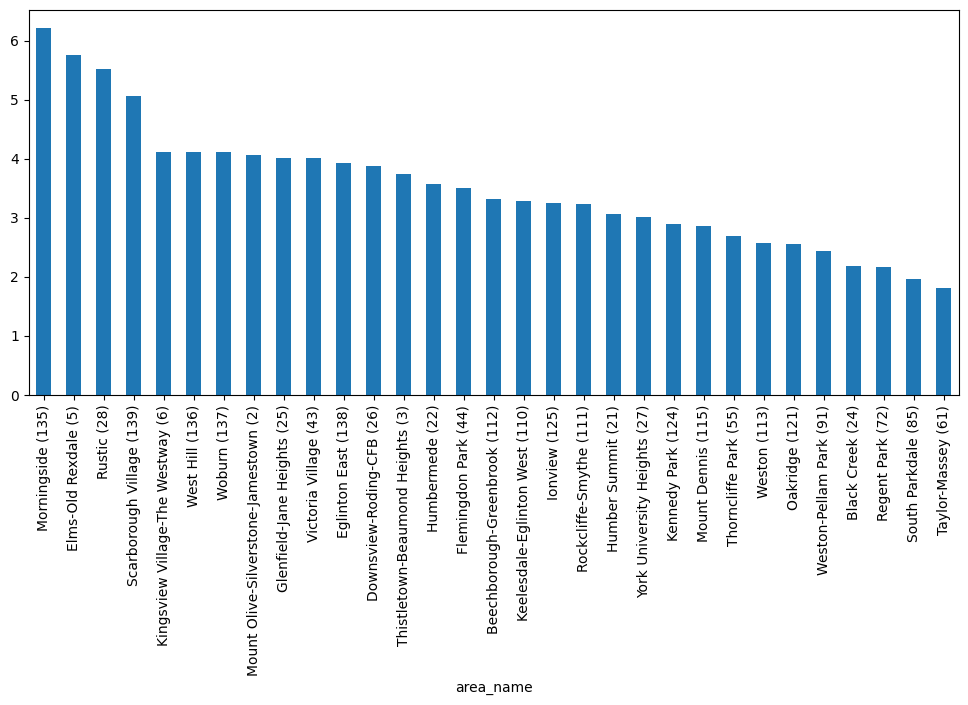

In [49]:
# plot bar plot
plt.figure(figsize=(12,5))
nia_address_bar = nia_address.groupby(['area_name'])['m_ttcstop_0'].mean()

nia_address_bar.sort_values(ascending=False).plot.bar()

# Plot Average Walking times to the Closest TTC Stop for each Neighbourhood Improvement Area

Text(0.1, 0.08, 'Source: Toronto Open Data')

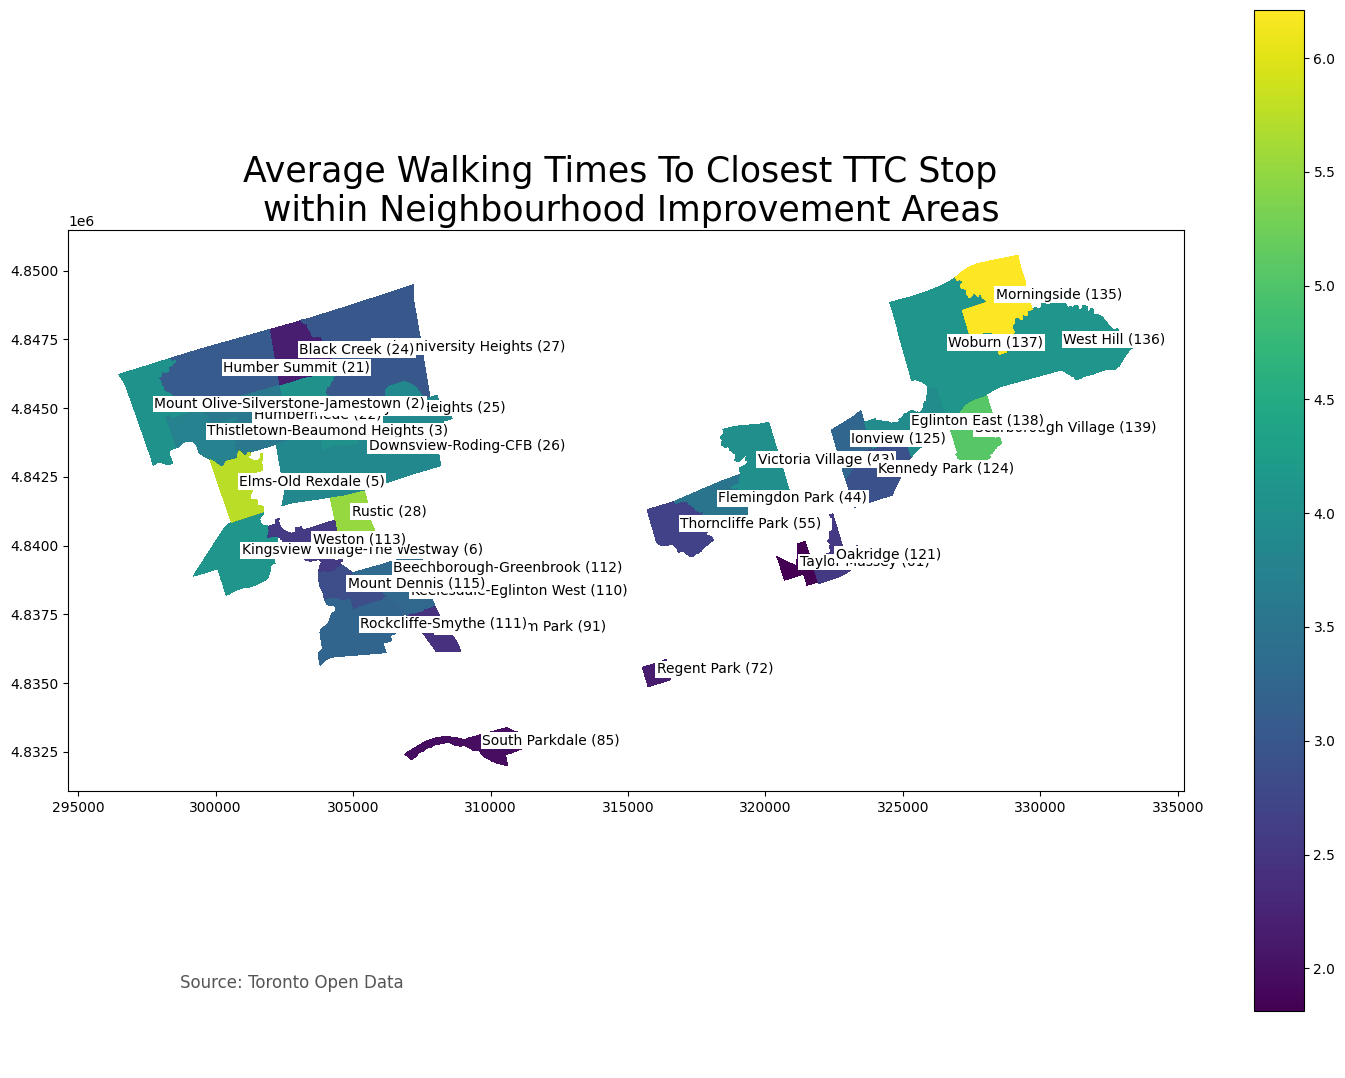

In [50]:
# plot Average Walking Times To Closest TTC Stop in Neighbourhood Improvement Areas
ax = nia_address.plot(figsize=(18, 13), column='nia_addr_avg_min', legend=True)
ax.set_title('Average Walking Times To Closest TTC Stop \n within Neighbourhood Improvement Areas', fontdict={'fontsize': '25', 'fontweight' : '3'})

# Plot labels and add a white box behind the label using the matplotlib bbox class.
for x, y, label in zip(nia_points.geometry.x, nia_points.geometry.y, nia_points["area_name"]):
    texts.append(plt.text(x, y, label, fontsize = 10, bbox=dict(boxstyle='square,pad=0.1', fc='white', ec='none')))
# create an annotation for the data source
ax.annotate('Source: Toronto Open Data',xy=(0.1, .08),  xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=12, color='#555555')

# Get bounds of each Neighbourhood Improvement Area polygon

We will list all of the Neighbourhood Improvement Areas. Select the index_left value corresponding to the Neighbourhood Improvement Area you want to display in the dataframe bell. We will use the bounding box function to obtain the polygon coordinates for each Neighbourhood Improvement Area. We will then use the bound box coordinates for a particular Neighbourhood Improvement Area polygon to show the walking times within the Neighbourhood Improvement Area.

In [51]:
# index_left and area_name
nia.area_name

0              York University Heights (27)
1          Thistletown-Beaumond Heights (3)
2                     Thorncliffe Park (55)
3                               Rustic (28)
4                 Scarborough Village (139)
5                       South Parkdale (85)
6                        Taylor-Massey (61)
7                        Humber Summit (21)
8                           Humbermede (22)
9                      Flemingdon Park (44)
10                            Ionview (125)
11              Glenfield-Jane Heights (25)
12                    Victoria Village (43)
13                          West Hill (136)
14                       Kennedy Park (124)
15        Kingsview Village-The Westway (6)
16           Keelesdale-Eglinton West (110)
17                       Mount Dennis (115)
18            Beechborough-Greenbrook (112)
19                           Oakridge (121)
20                      Eglinton East (138)
21                     Elms-Old Rexdale (5)
22                         Regen

In [52]:
# Get bounding box coordinates and area name for a particular Neighbourhood Improvement Area
# Pick index number from the list above and place it in the []
minx,miny,maxx,maxy = nia.bounds.iloc[4].values
# Pick the same index number from the list above and place it in the [] to get the area name
nia_area_name = nia.area_name.iloc[4]
nia_area_name

'Scarborough Village (139)'

# Plotting Neighbourhood Improvement Area using bounding box co-ordinates

Text(0.1, 0.05, 'Source: Toronto Open Data')

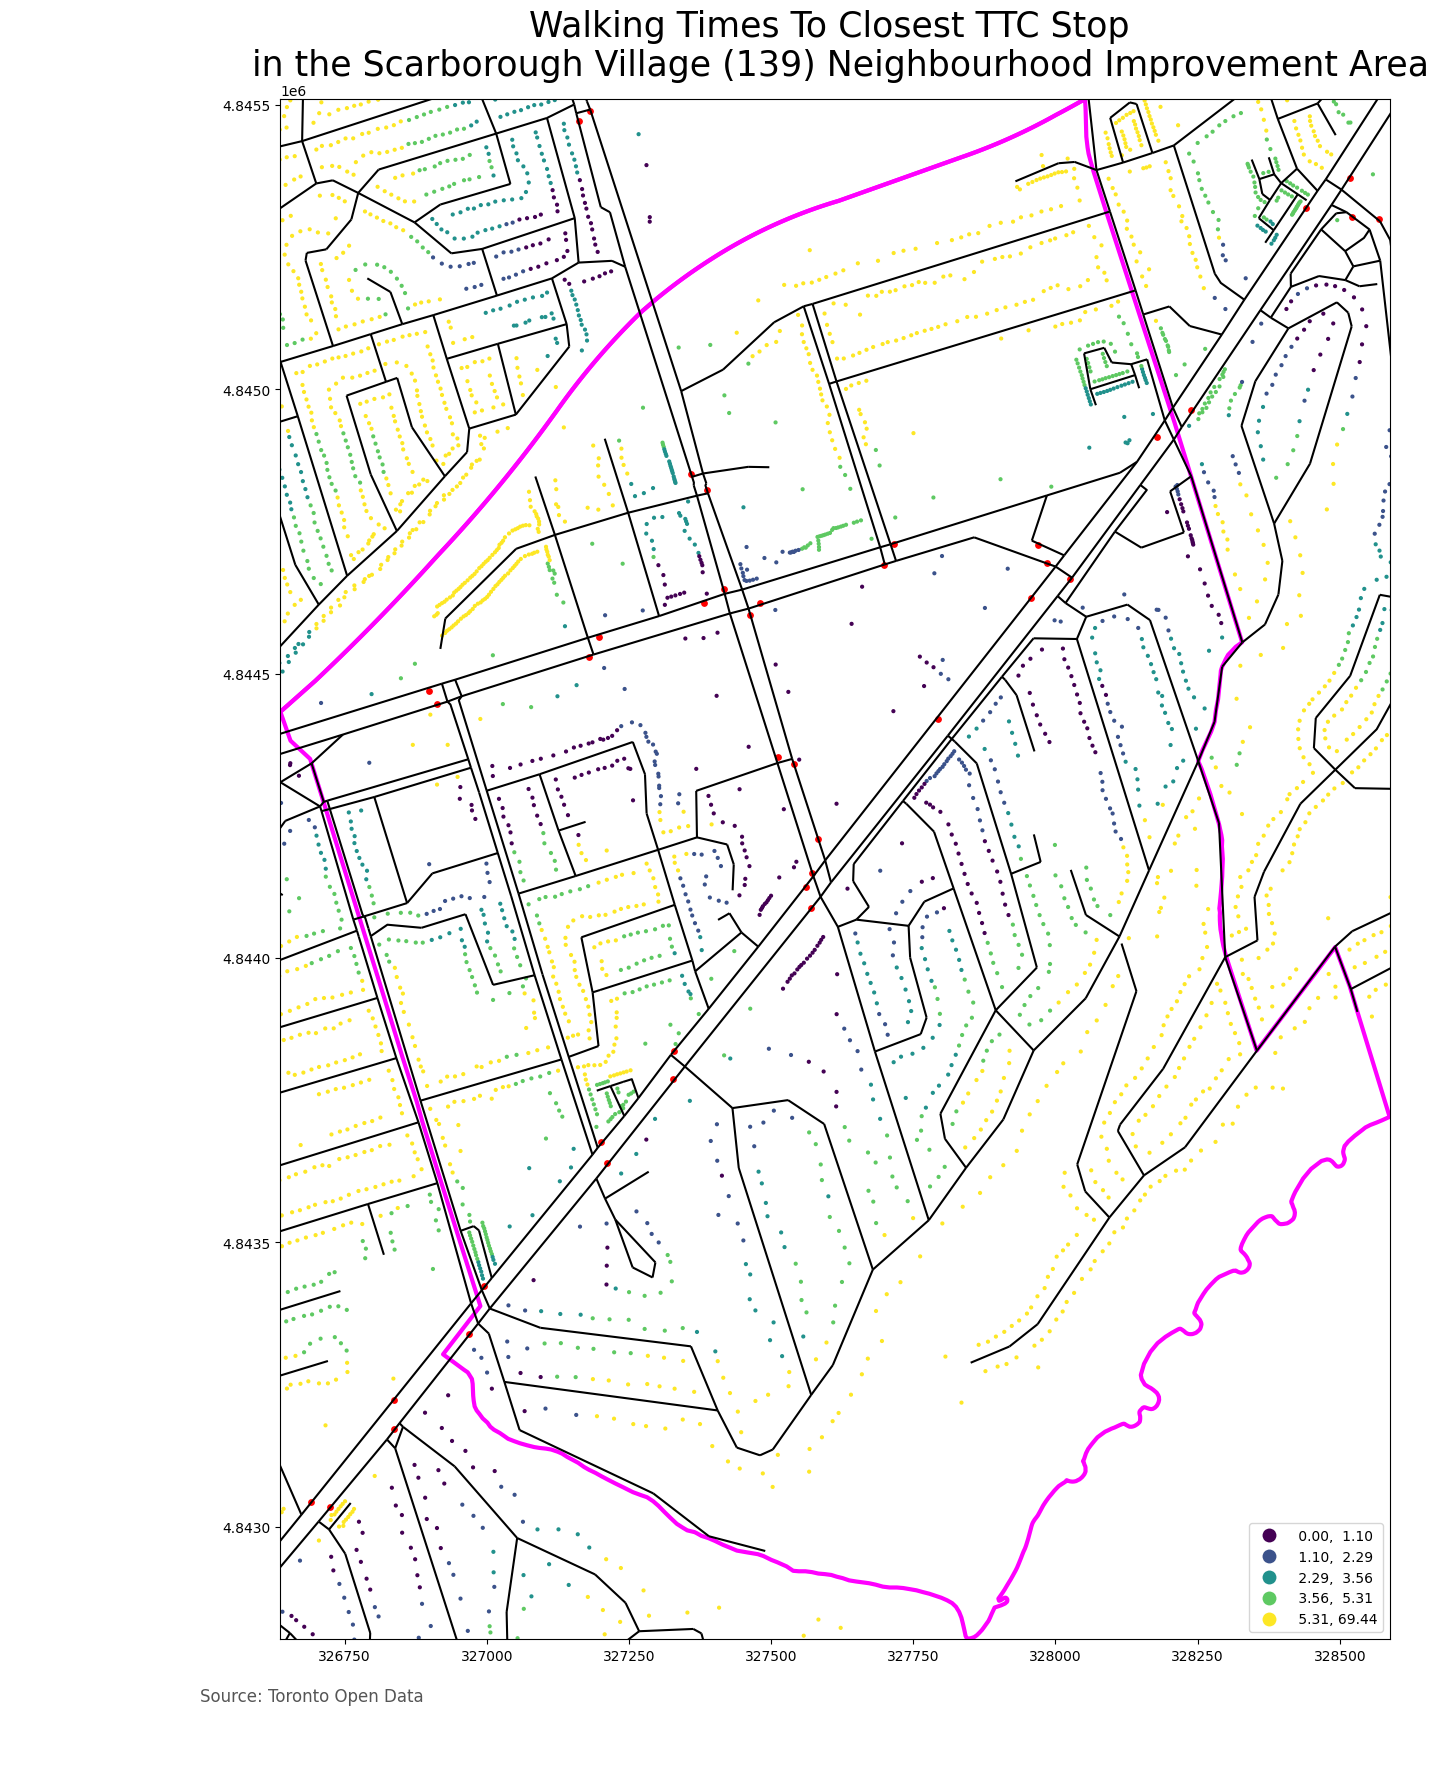

In [54]:
### plotting Neighbourhood Improvement Area using bounding box co-ordinates
#name = nia_area_name
ax = address.plot(figsize=(20, 20), column='m_ttcstop_0', scheme='quantiles', legend=True,markersize = 4)
nia.plot(ax=ax, facecolor='none', edgecolor='magenta', linewidth=3)
ttc_stop.plot(ax=ax, color='red', markersize =15)
pednet.plot(ax=ax,color='black', markersize =1)

# getting limits
ax.set(xlim=(minx, maxx), ylim=(miny, maxy))

# add a title
ax.set_title((('Walking Times To Closest TTC Stop \n in the {0} Neighbourhood Improvement Area').format(nia_area_name)), fontdict={'fontsize': '25', 'fontweight' : '3'})
# create an annotation for the data source
ax.annotate('Source: Toronto Open Data',xy=(0.1, .05),  xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=12, color='#555555')

#option to save figure
#fig.savefig("./ttc_stop_walkability.png", dpi=300)